In [1]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 
import csv
from tqdm import tqdm


from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [4]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [5]:
trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

In [6]:
class EpisodicDataLoader(torch.utils.data.DataLoader):
   def __init__(self, dataset, n_support, n_query, n_episodes, *args, **kwargs):
       super(EpisodicDataLoader, self).__init__(dataset, *args, **kwargs)
       self.n_support = n_support
       self.n_query = n_query
       self.n_episodes = n_episodes

   def __iter__(self):
       for _ in range(self.n_episodes):
           support_set = []
           query_set = []
           for class_idx in range(self.dataset.num_classes):
               data = self.dataset.get_class_data(class_idx)
               indices = torch.randperm(len(data))
               support_idx = indices[:self.n_support]
               query_idx = indices[self.n_support:self.n_support+self.n_query]
               support_set.append(data[support_idx])
               query_set.append(data[query_idx])
           yield torch.stack(support_set), torch.stack(query_set)

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted this line
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Change to Adam optimizer

In [9]:
import torch
import pandas as pd

num_epochs = 100

# Initialize lists to store losses and accuracies

writer = SummaryWriter()

# Initialize lists to store losses and accuracies
train_losses = []
valid_losses = []
train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (support_set, query_set) in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        support_set, query_set = support_set.to(device), query_set.to(device)
        embeddings = model(support_set)
        loss = criterion(embeddings, query_set)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(embeddings, 1)
        total_train += query_set.size(0)
        correct_train += (predicted_train == query_set).sum().item()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item()}')

    epoch_train_loss = running_loss / len(trainloader)
    accuracy_train = 100 * correct_train / total_train

    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for support_set, query_set in validloader:
            support_set, query_set = support_set.to(device), query_set.to(device)
            embeddings = model(support_set)
            loss = criterion(embeddings, query_set)
            valid_loss += loss.item()
            _, predicted = torch.max(embeddings, 1)
            total += query_set.size(0)
            correct += (predicted == query_set).sum().item()

    epoch_valid_loss = valid_loss / len(validloader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Training Accuracy: {accuracy_train:.2f}%, Validation Accuracy: {accuracy:.2f}%')

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    train_accuracies.append(accuracy_train)
    valid_accuracies.append(accuracy)

# Calculate training accuracy
train_accuracy = 100 * correct_train / total_train

# Log metrics to TensorBoard
# ... (previous code for logging)
writer.add_scalar('Loss/Training', epoch_train_loss, epoch)
writer.add_scalar('Loss/Validation', epoch_valid_loss, epoch)
writer.add_scalar('Accuracy/Validation', accuracy, epoch)
writer.add_scalar('Accuracy/Training', train_accuracy, epoch)


# Create a DataFrame
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Validation Loss': valid_losses,
    'Validation Accuracy': valid_accuracies
})

# Save the DataFrame to a CSV file
csv_file = 'few_shot_learning_metrics.csv'
df.to_csv(csv_file, index=False)


  5%|▍         | 10/205 [00:07<01:18,  2.49it/s]

Epoch [1/100], Step [10/205], Loss: 4.606282711029053


 10%|▉         | 20/205 [00:11<01:05,  2.80it/s]

Epoch [1/100], Step [20/205], Loss: 4.48220157623291


 15%|█▍        | 30/205 [00:15<01:02,  2.81it/s]

Epoch [1/100], Step [30/205], Loss: 4.473848819732666


 20%|█▉        | 40/205 [00:18<00:57,  2.86it/s]

Epoch [1/100], Step [40/205], Loss: 4.174065113067627


 24%|██▍       | 50/205 [00:22<00:53,  2.89it/s]

Epoch [1/100], Step [50/205], Loss: 4.233357906341553


 29%|██▉       | 60/205 [00:25<00:50,  2.88it/s]

Epoch [1/100], Step [60/205], Loss: 4.274988651275635


 34%|███▍      | 70/205 [00:29<00:46,  2.89it/s]

Epoch [1/100], Step [70/205], Loss: 4.454355239868164


 39%|███▉      | 80/205 [00:32<00:43,  2.88it/s]

Epoch [1/100], Step [80/205], Loss: 4.2508320808410645


 44%|████▍     | 90/205 [00:36<00:43,  2.63it/s]

Epoch [1/100], Step [90/205], Loss: 4.096689224243164


 49%|████▉     | 100/205 [00:39<00:37,  2.78it/s]

Epoch [1/100], Step [100/205], Loss: 4.046807289123535


 54%|█████▎    | 110/205 [00:43<00:33,  2.87it/s]

Epoch [1/100], Step [110/205], Loss: 4.088710308074951


 59%|█████▊    | 120/205 [00:47<00:30,  2.80it/s]

Epoch [1/100], Step [120/205], Loss: 4.313337802886963


 63%|██████▎   | 130/205 [00:50<00:28,  2.64it/s]

Epoch [1/100], Step [130/205], Loss: 4.173018455505371


 68%|██████▊   | 140/205 [00:54<00:22,  2.85it/s]

Epoch [1/100], Step [140/205], Loss: 4.271031856536865


 73%|███████▎  | 150/205 [00:58<00:19,  2.80it/s]

Epoch [1/100], Step [150/205], Loss: 4.01715087890625


 78%|███████▊  | 160/205 [01:01<00:16,  2.78it/s]

Epoch [1/100], Step [160/205], Loss: 4.174182415008545


 83%|████████▎ | 170/205 [01:05<00:13,  2.68it/s]

Epoch [1/100], Step [170/205], Loss: 4.1510210037231445


 88%|████████▊ | 180/205 [01:08<00:08,  2.89it/s]

Epoch [1/100], Step [180/205], Loss: 4.043939113616943


 93%|█████████▎| 190/205 [01:12<00:05,  2.83it/s]

Epoch [1/100], Step [190/205], Loss: 3.975407123565674


 98%|█████████▊| 200/205 [01:15<00:01,  2.87it/s]

Epoch [1/100], Step [200/205], Loss: 3.9785172939300537


100%|██████████| 205/205 [01:17<00:00,  2.65it/s]


Epoch [1/100] - Training Loss: 4.4104, Validation Loss: 3.9022, Training Accuracy: 5.28%, Validation Accuracy: 8.31%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [2/100], Step [10/205], Loss: 3.902776002883911


 10%|▉         | 20/205 [00:06<01:03,  2.94it/s]

Epoch [2/100], Step [20/205], Loss: 4.030770301818848


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [2/100], Step [30/205], Loss: 3.679011821746826


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]

Epoch [2/100], Step [40/205], Loss: 3.568315029144287


 24%|██▍       | 50/205 [00:17<00:56,  2.76it/s]

Epoch [2/100], Step [50/205], Loss: 3.717527389526367


 29%|██▉       | 60/205 [00:20<00:53,  2.73it/s]

Epoch [2/100], Step [60/205], Loss: 3.94181489944458


 34%|███▍      | 70/205 [00:24<00:46,  2.92it/s]

Epoch [2/100], Step [70/205], Loss: 4.005903244018555


 39%|███▉      | 80/205 [00:27<00:43,  2.91it/s]

Epoch [2/100], Step [80/205], Loss: 4.076193332672119


 44%|████▍     | 90/205 [00:31<00:39,  2.90it/s]

Epoch [2/100], Step [90/205], Loss: 3.9698781967163086


 49%|████▉     | 100/205 [00:34<00:35,  2.96it/s]

Epoch [2/100], Step [100/205], Loss: 3.5711991786956787


 54%|█████▎    | 110/205 [00:38<00:32,  2.95it/s]

Epoch [2/100], Step [110/205], Loss: 3.6495869159698486


 59%|█████▊    | 120/205 [00:41<00:29,  2.91it/s]

Epoch [2/100], Step [120/205], Loss: 3.6623587608337402


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [2/100], Step [130/205], Loss: 4.062020778656006


 68%|██████▊   | 140/205 [00:48<00:22,  2.93it/s]

Epoch [2/100], Step [140/205], Loss: 3.5269389152526855


 73%|███████▎  | 150/205 [00:51<00:18,  2.96it/s]

Epoch [2/100], Step [150/205], Loss: 3.8538339138031006


 78%|███████▊  | 160/205 [00:55<00:15,  2.92it/s]

Epoch [2/100], Step [160/205], Loss: 3.616753578186035


 83%|████████▎ | 170/205 [00:58<00:12,  2.85it/s]

Epoch [2/100], Step [170/205], Loss: 3.5370709896087646


 88%|████████▊ | 180/205 [01:02<00:08,  2.91it/s]

Epoch [2/100], Step [180/205], Loss: 3.7009360790252686


 93%|█████████▎| 190/205 [01:05<00:05,  2.98it/s]

Epoch [2/100], Step [190/205], Loss: 3.497828245162964


 98%|█████████▊| 200/205 [01:08<00:01,  2.99it/s]

Epoch [2/100], Step [200/205], Loss: 3.873582601547241


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [2/100] - Training Loss: 3.7922, Validation Loss: 3.5643, Training Accuracy: 8.70%, Validation Accuracy: 11.25%


  5%|▍         | 10/205 [00:03<01:07,  2.90it/s]

Epoch [3/100], Step [10/205], Loss: 3.546781539916992


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [3/100], Step [20/205], Loss: 3.3767871856689453


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [3/100], Step [30/205], Loss: 3.9411463737487793


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [3/100], Step [40/205], Loss: 3.449174642562866


 24%|██▍       | 50/205 [00:17<00:52,  2.95it/s]

Epoch [3/100], Step [50/205], Loss: 3.7581822872161865


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [3/100], Step [60/205], Loss: 3.6313798427581787


 34%|███▍      | 70/205 [00:23<00:46,  2.93it/s]

Epoch [3/100], Step [70/205], Loss: 3.4649829864501953


 39%|███▉      | 80/205 [00:27<00:43,  2.89it/s]

Epoch [3/100], Step [80/205], Loss: 3.624586343765259


 44%|████▍     | 90/205 [00:30<00:39,  2.89it/s]

Epoch [3/100], Step [90/205], Loss: 4.062744617462158


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [3/100], Step [100/205], Loss: 3.7831411361694336


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [3/100], Step [110/205], Loss: 3.538283586502075


 59%|█████▊    | 120/205 [00:41<00:28,  2.94it/s]

Epoch [3/100], Step [120/205], Loss: 3.424805164337158


 63%|██████▎   | 130/205 [00:44<00:25,  2.91it/s]

Epoch [3/100], Step [130/205], Loss: 3.6947131156921387


 68%|██████▊   | 140/205 [00:48<00:22,  2.90it/s]

Epoch [3/100], Step [140/205], Loss: 3.5744407176971436


 73%|███████▎  | 150/205 [00:51<00:18,  2.91it/s]

Epoch [3/100], Step [150/205], Loss: 3.448507785797119


 78%|███████▊  | 160/205 [00:54<00:15,  2.87it/s]

Epoch [3/100], Step [160/205], Loss: 3.4749982357025146


 83%|████████▎ | 170/205 [00:58<00:12,  2.88it/s]

Epoch [3/100], Step [170/205], Loss: 3.31215238571167


 88%|████████▊ | 180/205 [01:01<00:08,  2.86it/s]

Epoch [3/100], Step [180/205], Loss: 3.2900590896606445


 93%|█████████▎| 190/205 [01:05<00:05,  2.88it/s]

Epoch [3/100], Step [190/205], Loss: 3.4794371128082275


 98%|█████████▊| 200/205 [01:08<00:01,  2.88it/s]

Epoch [3/100], Step [200/205], Loss: 3.2961082458496094


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [3/100] - Training Loss: 3.5584, Validation Loss: 3.3787, Training Accuracy: 12.35%, Validation Accuracy: 16.38%


  5%|▍         | 10/205 [00:03<01:07,  2.88it/s]

Epoch [4/100], Step [10/205], Loss: 3.418163776397705


 10%|▉         | 20/205 [00:06<01:04,  2.87it/s]

Epoch [4/100], Step [20/205], Loss: 3.5382370948791504


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [4/100], Step [30/205], Loss: 3.512741804122925


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [4/100], Step [40/205], Loss: 3.5673632621765137


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]

Epoch [4/100], Step [50/205], Loss: 3.790796995162964


 29%|██▉       | 60/205 [00:20<00:49,  2.93it/s]

Epoch [4/100], Step [60/205], Loss: 3.41135573387146


 34%|███▍      | 70/205 [00:24<00:46,  2.92it/s]

Epoch [4/100], Step [70/205], Loss: 3.414553642272949


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [4/100], Step [80/205], Loss: 3.23543381690979


 44%|████▍     | 90/205 [00:31<00:39,  2.92it/s]

Epoch [4/100], Step [90/205], Loss: 2.690110683441162


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [4/100], Step [100/205], Loss: 3.2753922939300537


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [4/100], Step [110/205], Loss: 3.7177932262420654


 59%|█████▊    | 120/205 [00:41<00:29,  2.92it/s]

Epoch [4/100], Step [120/205], Loss: 3.5341646671295166


 63%|██████▎   | 130/205 [00:44<00:26,  2.83it/s]

Epoch [4/100], Step [130/205], Loss: 3.081604242324829


 68%|██████▊   | 140/205 [00:48<00:22,  2.93it/s]

Epoch [4/100], Step [140/205], Loss: 3.6121790409088135


 73%|███████▎  | 150/205 [00:51<00:19,  2.83it/s]

Epoch [4/100], Step [150/205], Loss: 2.9783687591552734


 78%|███████▊  | 160/205 [00:55<00:15,  2.90it/s]

Epoch [4/100], Step [160/205], Loss: 3.625535011291504


 83%|████████▎ | 170/205 [00:58<00:12,  2.84it/s]

Epoch [4/100], Step [170/205], Loss: 3.2897140979766846


 88%|████████▊ | 180/205 [01:02<00:08,  2.88it/s]

Epoch [4/100], Step [180/205], Loss: 3.412034749984741


 93%|█████████▎| 190/205 [01:05<00:05,  2.91it/s]

Epoch [4/100], Step [190/205], Loss: 3.1405460834503174


 98%|█████████▊| 200/205 [01:09<00:01,  2.93it/s]

Epoch [4/100], Step [200/205], Loss: 3.734046220779419


100%|██████████| 205/205 [01:10<00:00,  2.90it/s]


Epoch [4/100] - Training Loss: 3.4469, Validation Loss: 3.2873, Training Accuracy: 14.65%, Validation Accuracy: 17.36%


  5%|▍         | 10/205 [00:03<01:13,  2.65it/s]

Epoch [5/100], Step [10/205], Loss: 3.3108761310577393


 10%|▉         | 20/205 [00:07<01:14,  2.50it/s]

Epoch [5/100], Step [20/205], Loss: 3.1868715286254883


 15%|█▍        | 30/205 [00:11<01:03,  2.74it/s]

Epoch [5/100], Step [30/205], Loss: 3.711721658706665


 20%|█▉        | 40/205 [00:14<00:57,  2.86it/s]

Epoch [5/100], Step [40/205], Loss: 3.7231082916259766


 24%|██▍       | 50/205 [00:18<00:53,  2.87it/s]

Epoch [5/100], Step [50/205], Loss: 3.5268876552581787


 29%|██▉       | 60/205 [00:21<00:49,  2.90it/s]

Epoch [5/100], Step [60/205], Loss: 3.4558181762695312


 34%|███▍      | 70/205 [00:25<00:45,  2.96it/s]

Epoch [5/100], Step [70/205], Loss: 3.0124547481536865


 39%|███▉      | 80/205 [00:28<00:42,  2.96it/s]

Epoch [5/100], Step [80/205], Loss: 3.639359951019287


 44%|████▍     | 90/205 [00:32<00:39,  2.92it/s]

Epoch [5/100], Step [90/205], Loss: 3.1671903133392334


 49%|████▉     | 100/205 [00:35<00:36,  2.90it/s]

Epoch [5/100], Step [100/205], Loss: 3.37697696685791


 54%|█████▎    | 110/205 [00:39<00:32,  2.91it/s]

Epoch [5/100], Step [110/205], Loss: 3.068223237991333


 59%|█████▊    | 120/205 [00:42<00:29,  2.91it/s]

Epoch [5/100], Step [120/205], Loss: 3.4034509658813477


 63%|██████▎   | 130/205 [00:45<00:26,  2.88it/s]

Epoch [5/100], Step [130/205], Loss: 3.4308197498321533


 68%|██████▊   | 140/205 [00:49<00:22,  2.90it/s]

Epoch [5/100], Step [140/205], Loss: 3.4163336753845215


 73%|███████▎  | 150/205 [00:52<00:18,  2.92it/s]

Epoch [5/100], Step [150/205], Loss: 3.2922093868255615


 78%|███████▊  | 160/205 [00:56<00:15,  2.96it/s]

Epoch [5/100], Step [160/205], Loss: 3.0986435413360596


 83%|████████▎ | 170/205 [00:59<00:12,  2.89it/s]

Epoch [5/100], Step [170/205], Loss: 3.3450140953063965


 88%|████████▊ | 180/205 [01:03<00:08,  2.95it/s]

Epoch [5/100], Step [180/205], Loss: 3.2700672149658203


 93%|█████████▎| 190/205 [01:06<00:05,  2.93it/s]

Epoch [5/100], Step [190/205], Loss: 2.968883514404297


 98%|█████████▊| 200/205 [01:09<00:01,  2.99it/s]

Epoch [5/100], Step [200/205], Loss: 3.302438735961914


100%|██████████| 205/205 [01:11<00:00,  2.87it/s]


Epoch [5/100] - Training Loss: 3.3330, Validation Loss: 3.1749, Training Accuracy: 15.71%, Validation Accuracy: 18.83%


  5%|▍         | 10/205 [00:03<01:07,  2.88it/s]

Epoch [6/100], Step [10/205], Loss: 2.972024917602539


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [6/100], Step [20/205], Loss: 2.9053640365600586


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [6/100], Step [30/205], Loss: 3.044198989868164


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [6/100], Step [40/205], Loss: 3.6292295455932617


 24%|██▍       | 50/205 [00:17<00:53,  2.90it/s]

Epoch [6/100], Step [50/205], Loss: 3.8929555416107178


 29%|██▉       | 60/205 [00:20<00:50,  2.86it/s]

Epoch [6/100], Step [60/205], Loss: 3.133314609527588


 34%|███▍      | 70/205 [00:24<00:46,  2.93it/s]

Epoch [6/100], Step [70/205], Loss: 2.9717109203338623


 39%|███▉      | 80/205 [00:27<00:43,  2.90it/s]

Epoch [6/100], Step [80/205], Loss: 3.2672433853149414


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [6/100], Step [90/205], Loss: 3.3342058658599854


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [6/100], Step [100/205], Loss: 3.234663486480713


 54%|█████▎    | 110/205 [00:37<00:32,  2.94it/s]

Epoch [6/100], Step [110/205], Loss: 3.615060329437256


 59%|█████▊    | 120/205 [00:41<00:28,  2.95it/s]

Epoch [6/100], Step [120/205], Loss: 3.2998719215393066


 63%|██████▎   | 130/205 [00:44<00:25,  2.92it/s]

Epoch [6/100], Step [130/205], Loss: 3.4263598918914795


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [6/100], Step [140/205], Loss: 3.124107599258423


 73%|███████▎  | 150/205 [00:51<00:18,  2.94it/s]

Epoch [6/100], Step [150/205], Loss: 2.8075783252716064


 78%|███████▊  | 160/205 [00:54<00:15,  2.84it/s]

Epoch [6/100], Step [160/205], Loss: 3.02622389793396


 83%|████████▎ | 170/205 [00:58<00:12,  2.92it/s]

Epoch [6/100], Step [170/205], Loss: 3.154212236404419


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [6/100], Step [180/205], Loss: 3.8619542121887207


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [6/100], Step [190/205], Loss: 3.667978048324585


 98%|█████████▊| 200/205 [01:08<00:01,  2.95it/s]

Epoch [6/100], Step [200/205], Loss: 3.327430009841919


100%|██████████| 205/205 [01:09<00:00,  2.93it/s]


Epoch [6/100] - Training Loss: 3.2410, Validation Loss: 3.0212, Training Accuracy: 17.99%, Validation Accuracy: 22.00%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [7/100], Step [10/205], Loss: 2.784956693649292


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [7/100], Step [20/205], Loss: 3.095008373260498


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [7/100], Step [30/205], Loss: 3.181844711303711


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [7/100], Step [40/205], Loss: 3.238208532333374


 24%|██▍       | 50/205 [00:17<00:53,  2.89it/s]

Epoch [7/100], Step [50/205], Loss: 3.187894105911255


 29%|██▉       | 60/205 [00:20<00:49,  2.92it/s]

Epoch [7/100], Step [60/205], Loss: 3.116015672683716


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [7/100], Step [70/205], Loss: 3.482624053955078


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [7/100], Step [80/205], Loss: 3.283120632171631


 44%|████▍     | 90/205 [00:30<00:39,  2.91it/s]

Epoch [7/100], Step [90/205], Loss: 3.215885877609253


 49%|████▉     | 100/205 [00:34<00:35,  2.93it/s]

Epoch [7/100], Step [100/205], Loss: 2.873948335647583


 54%|█████▎    | 110/205 [00:37<00:32,  2.89it/s]

Epoch [7/100], Step [110/205], Loss: 3.4317281246185303


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [7/100], Step [120/205], Loss: 2.929149627685547


 63%|██████▎   | 130/205 [00:44<00:29,  2.55it/s]

Epoch [7/100], Step [130/205], Loss: 3.137054920196533


 68%|██████▊   | 140/205 [00:48<00:22,  2.92it/s]

Epoch [7/100], Step [140/205], Loss: 3.1516668796539307


 73%|███████▎  | 150/205 [00:51<00:18,  2.91it/s]

Epoch [7/100], Step [150/205], Loss: 3.1256394386291504


 78%|███████▊  | 160/205 [00:55<00:15,  2.89it/s]

Epoch [7/100], Step [160/205], Loss: 2.9091787338256836


 83%|████████▎ | 170/205 [00:58<00:12,  2.91it/s]

Epoch [7/100], Step [170/205], Loss: 2.815218687057495


 88%|████████▊ | 180/205 [01:01<00:08,  2.87it/s]

Epoch [7/100], Step [180/205], Loss: 2.854161500930786


 93%|█████████▎| 190/205 [01:05<00:05,  2.94it/s]

Epoch [7/100], Step [190/205], Loss: 2.809009075164795


 98%|█████████▊| 200/205 [01:08<00:01,  2.91it/s]

Epoch [7/100], Step [200/205], Loss: 3.055572509765625


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [7/100] - Training Loss: 3.1516, Validation Loss: 2.9028, Training Accuracy: 19.72%, Validation Accuracy: 24.21%


  5%|▍         | 10/205 [00:03<01:07,  2.90it/s]

Epoch [8/100], Step [10/205], Loss: 2.96623158454895


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [8/100], Step [20/205], Loss: 2.9962081909179688


 15%|█▍        | 30/205 [00:10<01:00,  2.92it/s]

Epoch [8/100], Step [30/205], Loss: 3.303945541381836


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]

Epoch [8/100], Step [40/205], Loss: 2.753929615020752


 24%|██▍       | 50/205 [00:17<00:53,  2.91it/s]

Epoch [8/100], Step [50/205], Loss: 3.2166213989257812


 29%|██▉       | 60/205 [00:20<00:50,  2.90it/s]

Epoch [8/100], Step [60/205], Loss: 3.4833006858825684


 34%|███▍      | 70/205 [00:24<00:46,  2.88it/s]

Epoch [8/100], Step [70/205], Loss: 3.3242650032043457


 39%|███▉      | 80/205 [00:27<00:42,  2.91it/s]

Epoch [8/100], Step [80/205], Loss: 3.028330087661743


 44%|████▍     | 90/205 [00:31<00:39,  2.89it/s]

Epoch [8/100], Step [90/205], Loss: 3.3863978385925293


 49%|████▉     | 100/205 [00:34<00:35,  2.93it/s]

Epoch [8/100], Step [100/205], Loss: 2.6851985454559326


 54%|█████▎    | 110/205 [00:38<00:32,  2.92it/s]

Epoch [8/100], Step [110/205], Loss: 2.721153497695923


 59%|█████▊    | 120/205 [00:41<00:29,  2.92it/s]

Epoch [8/100], Step [120/205], Loss: 3.2571372985839844


 63%|██████▎   | 130/205 [00:44<00:25,  2.89it/s]

Epoch [8/100], Step [130/205], Loss: 3.023407459259033


 68%|██████▊   | 140/205 [00:48<00:23,  2.82it/s]

Epoch [8/100], Step [140/205], Loss: 3.466986894607544


 73%|███████▎  | 150/205 [00:52<00:19,  2.89it/s]

Epoch [8/100], Step [150/205], Loss: 2.8684754371643066


 78%|███████▊  | 160/205 [00:55<00:15,  2.94it/s]

Epoch [8/100], Step [160/205], Loss: 2.938356399536133


 83%|████████▎ | 170/205 [00:59<00:12,  2.72it/s]

Epoch [8/100], Step [170/205], Loss: 2.803124189376831


 88%|████████▊ | 180/205 [01:02<00:08,  2.85it/s]

Epoch [8/100], Step [180/205], Loss: 3.488671064376831


 93%|█████████▎| 190/205 [01:06<00:05,  2.85it/s]

Epoch [8/100], Step [190/205], Loss: 3.4812746047973633


 98%|█████████▊| 200/205 [01:09<00:01,  2.85it/s]

Epoch [8/100], Step [200/205], Loss: 2.7643136978149414


100%|██████████| 205/205 [01:11<00:00,  2.87it/s]


Epoch [8/100] - Training Loss: 3.0107, Validation Loss: 2.7363, Training Accuracy: 23.38%, Validation Accuracy: 30.44%


  5%|▍         | 10/205 [00:03<01:06,  2.92it/s]

Epoch [9/100], Step [10/205], Loss: 2.765176296234131


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]

Epoch [9/100], Step [20/205], Loss: 2.893784284591675


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [9/100], Step [30/205], Loss: 2.510845899581909


 20%|█▉        | 40/205 [00:13<00:57,  2.88it/s]

Epoch [9/100], Step [40/205], Loss: 3.29211688041687


 24%|██▍       | 50/205 [00:17<00:52,  2.94it/s]

Epoch [9/100], Step [50/205], Loss: 2.8220343589782715


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [9/100], Step [60/205], Loss: 2.9538393020629883


 34%|███▍      | 70/205 [00:23<00:46,  2.93it/s]

Epoch [9/100], Step [70/205], Loss: 2.963777780532837


 39%|███▉      | 80/205 [00:27<00:43,  2.89it/s]

Epoch [9/100], Step [80/205], Loss: 2.521529197692871


 44%|████▍     | 90/205 [00:30<00:39,  2.90it/s]

Epoch [9/100], Step [90/205], Loss: 2.5848612785339355


 49%|████▉     | 100/205 [00:34<00:36,  2.90it/s]

Epoch [9/100], Step [100/205], Loss: 3.2031450271606445


 54%|█████▎    | 110/205 [00:37<00:32,  2.89it/s]

Epoch [9/100], Step [110/205], Loss: 2.6881351470947266


 59%|█████▊    | 120/205 [00:41<00:29,  2.91it/s]

Epoch [9/100], Step [120/205], Loss: 3.173128843307495


 63%|██████▎   | 130/205 [00:44<00:25,  2.89it/s]

Epoch [9/100], Step [130/205], Loss: 3.1127500534057617


 68%|██████▊   | 140/205 [00:48<00:22,  2.88it/s]

Epoch [9/100], Step [140/205], Loss: 2.6560964584350586


 73%|███████▎  | 150/205 [00:51<00:18,  2.92it/s]

Epoch [9/100], Step [150/205], Loss: 2.605802536010742


 78%|███████▊  | 160/205 [00:55<00:15,  2.93it/s]

Epoch [9/100], Step [160/205], Loss: 2.9075169563293457


 83%|████████▎ | 170/205 [00:58<00:11,  2.93it/s]

Epoch [9/100], Step [170/205], Loss: 3.0299761295318604


 88%|████████▊ | 180/205 [01:01<00:08,  2.93it/s]

Epoch [9/100], Step [180/205], Loss: 3.1132736206054688


 93%|█████████▎| 190/205 [01:05<00:05,  2.92it/s]

Epoch [9/100], Step [190/205], Loss: 2.38919734954834


 98%|█████████▊| 200/205 [01:08<00:01,  2.92it/s]

Epoch [9/100], Step [200/205], Loss: 2.5945065021514893


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [9/100] - Training Loss: 2.8672, Validation Loss: 2.6528, Training Accuracy: 26.13%, Validation Accuracy: 31.05%


  5%|▍         | 10/205 [00:03<01:07,  2.90it/s]

Epoch [10/100], Step [10/205], Loss: 3.167900323867798


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [10/100], Step [20/205], Loss: 2.6189684867858887


 15%|█▍        | 30/205 [00:10<01:00,  2.90it/s]

Epoch [10/100], Step [30/205], Loss: 2.815890312194824


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [10/100], Step [40/205], Loss: 2.413078546524048


 24%|██▍       | 50/205 [00:17<00:53,  2.90it/s]

Epoch [10/100], Step [50/205], Loss: 2.994295120239258


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [10/100], Step [60/205], Loss: 2.6022961139678955


 34%|███▍      | 70/205 [00:24<00:46,  2.93it/s]

Epoch [10/100], Step [70/205], Loss: 2.8827767372131348


 39%|███▉      | 80/205 [00:27<00:42,  2.93it/s]

Epoch [10/100], Step [80/205], Loss: 2.897270917892456


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [10/100], Step [90/205], Loss: 2.6871702671051025


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [10/100], Step [100/205], Loss: 2.622472047805786


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [10/100], Step [110/205], Loss: 2.615007162094116


 59%|█████▊    | 120/205 [00:41<00:28,  2.94it/s]

Epoch [10/100], Step [120/205], Loss: 2.810434103012085


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [10/100], Step [130/205], Loss: 2.9482643604278564


 68%|██████▊   | 140/205 [00:47<00:21,  2.98it/s]

Epoch [10/100], Step [140/205], Loss: 3.051619529724121


 73%|███████▎  | 150/205 [00:51<00:18,  2.95it/s]

Epoch [10/100], Step [150/205], Loss: 2.934884786605835


 78%|███████▊  | 160/205 [00:54<00:14,  3.01it/s]

Epoch [10/100], Step [160/205], Loss: 2.9240314960479736


 83%|████████▎ | 170/205 [00:58<00:11,  2.96it/s]

Epoch [10/100], Step [170/205], Loss: 2.6899871826171875


 88%|████████▊ | 180/205 [01:01<00:08,  2.91it/s]

Epoch [10/100], Step [180/205], Loss: 2.901848793029785


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [10/100], Step [190/205], Loss: 3.330596685409546


 98%|█████████▊| 200/205 [01:08<00:01,  2.99it/s]

Epoch [10/100], Step [200/205], Loss: 2.313053607940674


100%|██████████| 205/205 [01:10<00:00,  2.93it/s]


Epoch [10/100] - Training Loss: 2.7075, Validation Loss: 2.4620, Training Accuracy: 29.49%, Validation Accuracy: 34.84%


  5%|▍         | 10/205 [00:03<01:05,  2.95it/s]

Epoch [11/100], Step [10/205], Loss: 2.914158344268799


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [11/100], Step [20/205], Loss: 2.5939741134643555


 15%|█▍        | 30/205 [00:10<01:00,  2.89it/s]

Epoch [11/100], Step [30/205], Loss: 2.3425843715667725


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [11/100], Step [40/205], Loss: 3.1123476028442383


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [11/100], Step [50/205], Loss: 2.1656367778778076


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [11/100], Step [60/205], Loss: 2.6273813247680664


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [11/100], Step [70/205], Loss: 2.4382033348083496


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [11/100], Step [80/205], Loss: 2.61372447013855


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [11/100], Step [90/205], Loss: 2.939952850341797


 49%|████▉     | 100/205 [00:34<00:35,  2.96it/s]

Epoch [11/100], Step [100/205], Loss: 2.7916343212127686


 54%|█████▎    | 110/205 [00:37<00:33,  2.85it/s]

Epoch [11/100], Step [110/205], Loss: 2.3283848762512207


 59%|█████▊    | 120/205 [00:40<00:29,  2.92it/s]

Epoch [11/100], Step [120/205], Loss: 2.40664005279541


 63%|██████▎   | 130/205 [00:44<00:27,  2.76it/s]

Epoch [11/100], Step [130/205], Loss: 2.684810161590576


 68%|██████▊   | 140/205 [00:48<00:22,  2.85it/s]

Epoch [11/100], Step [140/205], Loss: 3.044808864593506


 73%|███████▎  | 150/205 [00:51<00:19,  2.76it/s]

Epoch [11/100], Step [150/205], Loss: 2.5141654014587402


 78%|███████▊  | 160/205 [00:55<00:15,  2.83it/s]

Epoch [11/100], Step [160/205], Loss: 2.3477206230163574


 83%|████████▎ | 170/205 [00:58<00:11,  2.93it/s]

Epoch [11/100], Step [170/205], Loss: 2.8912432193756104


 88%|████████▊ | 180/205 [01:02<00:08,  2.95it/s]

Epoch [11/100], Step [180/205], Loss: 2.697528600692749


 93%|█████████▎| 190/205 [01:05<00:05,  2.96it/s]

Epoch [11/100], Step [190/205], Loss: 2.473078489303589


 98%|█████████▊| 200/205 [01:09<00:01,  2.95it/s]

Epoch [11/100], Step [200/205], Loss: 2.518582582473755


100%|██████████| 205/205 [01:10<00:00,  2.90it/s]


Epoch [11/100] - Training Loss: 2.6058, Validation Loss: 2.3086, Training Accuracy: 31.82%, Validation Accuracy: 39.36%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [12/100], Step [10/205], Loss: 2.345928430557251


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [12/100], Step [20/205], Loss: 3.084177255630493


 15%|█▍        | 30/205 [00:10<00:59,  2.97it/s]

Epoch [12/100], Step [30/205], Loss: 2.8255999088287354


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [12/100], Step [40/205], Loss: 2.3260996341705322


 24%|██▍       | 50/205 [00:17<00:55,  2.81it/s]

Epoch [12/100], Step [50/205], Loss: 2.6723556518554688


 29%|██▉       | 60/205 [00:20<00:52,  2.75it/s]

Epoch [12/100], Step [60/205], Loss: 2.1859023571014404


 34%|███▍      | 70/205 [00:24<00:47,  2.84it/s]

Epoch [12/100], Step [70/205], Loss: 2.4608001708984375


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [12/100], Step [80/205], Loss: 2.6327760219573975


 44%|████▍     | 90/205 [00:31<00:39,  2.95it/s]

Epoch [12/100], Step [90/205], Loss: 2.7564241886138916


 49%|████▉     | 100/205 [00:34<00:36,  2.91it/s]

Epoch [12/100], Step [100/205], Loss: 2.3735883235931396


 54%|█████▎    | 110/205 [00:37<00:32,  2.92it/s]

Epoch [12/100], Step [110/205], Loss: 2.753056764602661


 59%|█████▊    | 120/205 [00:41<00:29,  2.91it/s]

Epoch [12/100], Step [120/205], Loss: 2.546731948852539


 63%|██████▎   | 130/205 [00:44<00:25,  2.92it/s]

Epoch [12/100], Step [130/205], Loss: 2.159876585006714


 68%|██████▊   | 140/205 [00:48<00:22,  2.90it/s]

Epoch [12/100], Step [140/205], Loss: 2.6138157844543457


 73%|███████▎  | 150/205 [00:51<00:18,  2.93it/s]

Epoch [12/100], Step [150/205], Loss: 2.477429151535034


 78%|███████▊  | 160/205 [00:55<00:15,  2.90it/s]

Epoch [12/100], Step [160/205], Loss: 2.4096872806549072


 83%|████████▎ | 170/205 [00:58<00:12,  2.89it/s]

Epoch [12/100], Step [170/205], Loss: 2.487076759338379


 88%|████████▊ | 180/205 [01:02<00:08,  2.84it/s]

Epoch [12/100], Step [180/205], Loss: 2.3850293159484863


 93%|█████████▎| 190/205 [01:05<00:05,  2.97it/s]

Epoch [12/100], Step [190/205], Loss: 2.562476634979248


 98%|█████████▊| 200/205 [01:08<00:01,  2.93it/s]

Epoch [12/100], Step [200/205], Loss: 2.5078556537628174


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [12/100] - Training Loss: 2.5072, Validation Loss: 2.3075, Training Accuracy: 34.10%, Validation Accuracy: 40.10%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [13/100], Step [10/205], Loss: 2.853975772857666


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [13/100], Step [20/205], Loss: 2.455641746520996


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [13/100], Step [30/205], Loss: 2.3408703804016113


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [13/100], Step [40/205], Loss: 2.0150465965270996


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [13/100], Step [50/205], Loss: 2.5226733684539795


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [13/100], Step [60/205], Loss: 2.6871488094329834


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [13/100], Step [70/205], Loss: 2.198338270187378


 39%|███▉      | 80/205 [00:26<00:42,  2.97it/s]

Epoch [13/100], Step [80/205], Loss: 2.5628163814544678


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [13/100], Step [90/205], Loss: 2.5085339546203613


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [13/100], Step [100/205], Loss: 2.357146739959717


 54%|█████▎    | 110/205 [00:36<00:31,  2.97it/s]

Epoch [13/100], Step [110/205], Loss: 2.8769805431365967


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [13/100], Step [120/205], Loss: 2.3531594276428223


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [13/100], Step [130/205], Loss: 2.2256016731262207


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [13/100], Step [140/205], Loss: 2.2946863174438477


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [13/100], Step [150/205], Loss: 2.2786622047424316


 78%|███████▊  | 160/205 [00:53<00:15,  2.92it/s]

Epoch [13/100], Step [160/205], Loss: 2.7105603218078613


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [13/100], Step [170/205], Loss: 1.8190598487854004


 88%|████████▊ | 180/205 [01:00<00:08,  2.93it/s]

Epoch [13/100], Step [180/205], Loss: 2.596825122833252


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [13/100], Step [190/205], Loss: 2.242119073867798


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [13/100], Step [200/205], Loss: 2.7937843799591064


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [13/100] - Training Loss: 2.4016, Validation Loss: 2.2064, Training Accuracy: 36.94%, Validation Accuracy: 41.81%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [14/100], Step [10/205], Loss: 2.4454193115234375


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [14/100], Step [20/205], Loss: 2.000300407409668


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [14/100], Step [30/205], Loss: 2.326596260070801


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [14/100], Step [40/205], Loss: 2.323634386062622


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [14/100], Step [50/205], Loss: 2.0760250091552734


 29%|██▉       | 60/205 [00:20<00:49,  2.96it/s]

Epoch [14/100], Step [60/205], Loss: 2.014199733734131


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [14/100], Step [70/205], Loss: 2.137895345687866


 39%|███▉      | 80/205 [00:26<00:42,  2.96it/s]

Epoch [14/100], Step [80/205], Loss: 1.9844967126846313


 44%|████▍     | 90/205 [00:30<00:39,  2.92it/s]

Epoch [14/100], Step [90/205], Loss: 2.4230926036834717


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [14/100], Step [100/205], Loss: 2.4432663917541504


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [14/100], Step [110/205], Loss: 2.2716619968414307


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [14/100], Step [120/205], Loss: 1.774224042892456


 63%|██████▎   | 130/205 [00:43<00:25,  2.99it/s]

Epoch [14/100], Step [130/205], Loss: 2.145703077316284


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [14/100], Step [140/205], Loss: 2.693861722946167


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [14/100], Step [150/205], Loss: 2.342789649963379


 78%|███████▊  | 160/205 [00:53<00:15,  2.99it/s]

Epoch [14/100], Step [160/205], Loss: 1.9812488555908203


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [14/100], Step [170/205], Loss: 1.9560656547546387


 88%|████████▊ | 180/205 [01:00<00:08,  2.93it/s]

Epoch [14/100], Step [180/205], Loss: 2.035400152206421


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [14/100], Step [190/205], Loss: 2.2134408950805664


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [14/100], Step [200/205], Loss: 2.259381055831909


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [14/100] - Training Loss: 2.3183, Validation Loss: 2.2325, Training Accuracy: 38.03%, Validation Accuracy: 41.44%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [15/100], Step [10/205], Loss: 2.24014949798584


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [15/100], Step [20/205], Loss: 2.3614022731781006


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [15/100], Step [30/205], Loss: 2.0946269035339355


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [15/100], Step [40/205], Loss: 2.487468719482422


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [15/100], Step [50/205], Loss: 2.214602470397949


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [15/100], Step [60/205], Loss: 2.099472761154175


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [15/100], Step [70/205], Loss: 2.155522584915161


 39%|███▉      | 80/205 [00:26<00:42,  2.96it/s]

Epoch [15/100], Step [80/205], Loss: 2.0608010292053223


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [15/100], Step [90/205], Loss: 2.291419744491577


 49%|████▉     | 100/205 [00:33<00:35,  3.00it/s]

Epoch [15/100], Step [100/205], Loss: 2.4584596157073975


 54%|█████▎    | 110/205 [00:36<00:31,  3.01it/s]

Epoch [15/100], Step [110/205], Loss: 2.7272164821624756


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [15/100], Step [120/205], Loss: 1.727356195449829


 63%|██████▎   | 130/205 [00:43<00:26,  2.87it/s]

Epoch [15/100], Step [130/205], Loss: 1.9968376159667969


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [15/100], Step [140/205], Loss: 2.6756649017333984


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [15/100], Step [150/205], Loss: 1.7392346858978271


 78%|███████▊  | 160/205 [00:53<00:14,  3.05it/s]

Epoch [15/100], Step [160/205], Loss: 2.190049648284912


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [15/100], Step [170/205], Loss: 2.0808489322662354


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [15/100], Step [180/205], Loss: 2.0233969688415527


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [15/100], Step [190/205], Loss: 2.295349597930908


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [15/100], Step [200/205], Loss: 2.3398518562316895


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [15/100] - Training Loss: 2.2823, Validation Loss: 2.0662, Training Accuracy: 39.47%, Validation Accuracy: 45.97%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [16/100], Step [10/205], Loss: 1.6900535821914673


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [16/100], Step [20/205], Loss: 2.0651323795318604


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [16/100], Step [30/205], Loss: 2.325152635574341


 20%|█▉        | 40/205 [00:14<01:05,  2.50it/s]

Epoch [16/100], Step [40/205], Loss: 2.208638906478882


 24%|██▍       | 50/205 [00:17<00:54,  2.84it/s]

Epoch [16/100], Step [50/205], Loss: 2.007871150970459


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [16/100], Step [60/205], Loss: 2.4846036434173584


 34%|███▍      | 70/205 [00:24<00:45,  2.98it/s]

Epoch [16/100], Step [70/205], Loss: 2.3015871047973633


 39%|███▉      | 80/205 [00:27<00:43,  2.85it/s]

Epoch [16/100], Step [80/205], Loss: 1.9727472066879272


 44%|████▍     | 90/205 [00:31<00:43,  2.65it/s]

Epoch [16/100], Step [90/205], Loss: 2.0185515880584717


 49%|████▉     | 100/205 [00:34<00:35,  2.93it/s]

Epoch [16/100], Step [100/205], Loss: 1.807157039642334


 54%|█████▎    | 110/205 [00:38<00:31,  3.01it/s]

Epoch [16/100], Step [110/205], Loss: 2.148710250854492


 59%|█████▊    | 120/205 [00:41<00:28,  3.01it/s]

Epoch [16/100], Step [120/205], Loss: 2.2094600200653076


 63%|██████▎   | 130/205 [00:44<00:25,  2.99it/s]

Epoch [16/100], Step [130/205], Loss: 2.0826361179351807


 68%|██████▊   | 140/205 [00:48<00:22,  2.90it/s]

Epoch [16/100], Step [140/205], Loss: 1.926379919052124


 73%|███████▎  | 150/205 [00:51<00:18,  2.96it/s]

Epoch [16/100], Step [150/205], Loss: 2.2571158409118652


 78%|███████▊  | 160/205 [00:55<00:15,  2.96it/s]

Epoch [16/100], Step [160/205], Loss: 1.6055878400802612


 83%|████████▎ | 170/205 [00:59<00:13,  2.56it/s]

Epoch [16/100], Step [170/205], Loss: 2.3103525638580322


 88%|████████▊ | 180/205 [01:02<00:09,  2.68it/s]

Epoch [16/100], Step [180/205], Loss: 2.094620943069458


 93%|█████████▎| 190/205 [01:06<00:05,  2.53it/s]

Epoch [16/100], Step [190/205], Loss: 2.296422243118286


 98%|█████████▊| 200/205 [01:10<00:01,  2.68it/s]

Epoch [16/100], Step [200/205], Loss: 2.3134243488311768


100%|██████████| 205/205 [01:12<00:00,  2.84it/s]


Epoch [16/100] - Training Loss: 2.1821, Validation Loss: 1.9258, Training Accuracy: 41.61%, Validation Accuracy: 49.76%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [17/100], Step [10/205], Loss: 1.846531867980957


 10%|▉         | 20/205 [00:06<01:03,  2.91it/s]

Epoch [17/100], Step [20/205], Loss: 2.253922462463379


 15%|█▍        | 30/205 [00:10<00:59,  2.97it/s]

Epoch [17/100], Step [30/205], Loss: 2.2281417846679688


 20%|█▉        | 40/205 [00:13<00:54,  3.03it/s]

Epoch [17/100], Step [40/205], Loss: 1.942008137702942


 24%|██▍       | 50/205 [00:16<00:51,  2.98it/s]

Epoch [17/100], Step [50/205], Loss: 2.1830430030822754


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [17/100], Step [60/205], Loss: 1.9107757806777954


 34%|███▍      | 70/205 [00:24<00:54,  2.48it/s]

Epoch [17/100], Step [70/205], Loss: 2.386000394821167


 39%|███▉      | 80/205 [00:27<00:46,  2.66it/s]

Epoch [17/100], Step [80/205], Loss: 2.7908425331115723


 44%|████▍     | 90/205 [00:31<00:41,  2.80it/s]

Epoch [17/100], Step [90/205], Loss: 2.3141472339630127


 49%|████▉     | 100/205 [00:35<00:36,  2.89it/s]

Epoch [17/100], Step [100/205], Loss: 1.6972031593322754


 54%|█████▎    | 110/205 [00:38<00:32,  2.96it/s]

Epoch [17/100], Step [110/205], Loss: 2.1099936962127686


 59%|█████▊    | 120/205 [00:41<00:31,  2.74it/s]

Epoch [17/100], Step [120/205], Loss: 2.3194656372070312


 63%|██████▎   | 130/205 [00:45<00:25,  2.93it/s]

Epoch [17/100], Step [130/205], Loss: 1.9306557178497314


 68%|██████▊   | 140/205 [00:48<00:22,  2.93it/s]

Epoch [17/100], Step [140/205], Loss: 2.0168910026550293


 73%|███████▎  | 150/205 [00:52<00:19,  2.76it/s]

Epoch [17/100], Step [150/205], Loss: 2.128958225250244


 78%|███████▊  | 160/205 [00:55<00:15,  2.95it/s]

Epoch [17/100], Step [160/205], Loss: 2.175173282623291


 83%|████████▎ | 170/205 [00:59<00:12,  2.88it/s]

Epoch [17/100], Step [170/205], Loss: 1.7461178302764893


 88%|████████▊ | 180/205 [01:03<00:09,  2.64it/s]

Epoch [17/100], Step [180/205], Loss: 1.731300711631775


 93%|█████████▎| 190/205 [01:06<00:05,  2.63it/s]

Epoch [17/100], Step [190/205], Loss: 2.5834708213806152


 98%|█████████▊| 200/205 [01:10<00:01,  2.66it/s]

Epoch [17/100], Step [200/205], Loss: 2.2654924392700195


100%|██████████| 205/205 [01:12<00:00,  2.84it/s]


Epoch [17/100] - Training Loss: 2.1605, Validation Loss: 2.0631, Training Accuracy: 42.20%, Validation Accuracy: 45.11%


  5%|▍         | 10/205 [00:03<01:07,  2.88it/s]

Epoch [18/100], Step [10/205], Loss: 2.2344601154327393


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [18/100], Step [20/205], Loss: 1.6069519519805908


 15%|█▍        | 30/205 [00:10<01:02,  2.80it/s]

Epoch [18/100], Step [30/205], Loss: 1.7407795190811157


 20%|█▉        | 40/205 [00:14<00:58,  2.81it/s]

Epoch [18/100], Step [40/205], Loss: 2.1440398693084717


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [18/100], Step [50/205], Loss: 1.593117117881775


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [18/100], Step [60/205], Loss: 2.4221088886260986


 34%|███▍      | 70/205 [00:24<00:45,  2.94it/s]

Epoch [18/100], Step [70/205], Loss: 1.7376047372817993


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [18/100], Step [80/205], Loss: 1.9839746952056885


 44%|████▍     | 90/205 [00:31<00:38,  2.95it/s]

Epoch [18/100], Step [90/205], Loss: 1.8017303943634033


 49%|████▉     | 100/205 [00:34<00:35,  2.96it/s]

Epoch [18/100], Step [100/205], Loss: 2.418653726577759


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [18/100], Step [110/205], Loss: 2.249070167541504


 59%|█████▊    | 120/205 [00:41<00:28,  2.97it/s]

Epoch [18/100], Step [120/205], Loss: 1.7490805387496948


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [18/100], Step [130/205], Loss: 1.883880853652954


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [18/100], Step [140/205], Loss: 2.03688645362854


 73%|███████▎  | 150/205 [00:51<00:18,  3.00it/s]

Epoch [18/100], Step [150/205], Loss: 2.0161612033843994


 78%|███████▊  | 160/205 [00:54<00:14,  3.02it/s]

Epoch [18/100], Step [160/205], Loss: 1.9558714628219604


 83%|████████▎ | 170/205 [00:57<00:11,  3.01it/s]

Epoch [18/100], Step [170/205], Loss: 2.2385048866271973


 88%|████████▊ | 180/205 [01:01<00:08,  2.91it/s]

Epoch [18/100], Step [180/205], Loss: 2.277571201324463


 93%|█████████▎| 190/205 [01:05<00:05,  2.58it/s]

Epoch [18/100], Step [190/205], Loss: 2.091831684112549


 98%|█████████▊| 200/205 [01:08<00:01,  2.72it/s]

Epoch [18/100], Step [200/205], Loss: 2.1477389335632324


100%|██████████| 205/205 [01:10<00:00,  2.90it/s]


Epoch [18/100] - Training Loss: 2.0695, Validation Loss: 1.8855, Training Accuracy: 44.17%, Validation Accuracy: 49.39%


  5%|▍         | 10/205 [00:03<01:11,  2.74it/s]

Epoch [19/100], Step [10/205], Loss: 2.193464994430542


 10%|▉         | 20/205 [00:07<01:04,  2.85it/s]

Epoch [19/100], Step [20/205], Loss: 2.082632303237915


 15%|█▍        | 30/205 [00:10<01:06,  2.63it/s]

Epoch [19/100], Step [30/205], Loss: 2.0451200008392334


 20%|█▉        | 40/205 [00:14<00:57,  2.88it/s]

Epoch [19/100], Step [40/205], Loss: 2.3166372776031494


 24%|██▍       | 50/205 [00:17<00:54,  2.85it/s]

Epoch [19/100], Step [50/205], Loss: 1.6179569959640503


 29%|██▉       | 60/205 [00:21<00:50,  2.87it/s]

Epoch [19/100], Step [60/205], Loss: 2.167160749435425


 34%|███▍      | 70/205 [00:24<00:46,  2.91it/s]

Epoch [19/100], Step [70/205], Loss: 2.0537075996398926


 39%|███▉      | 80/205 [00:28<00:44,  2.84it/s]

Epoch [19/100], Step [80/205], Loss: 1.7919667959213257


 44%|████▍     | 90/205 [00:31<00:43,  2.65it/s]

Epoch [19/100], Step [90/205], Loss: 2.20745587348938


 49%|████▉     | 100/205 [00:35<00:36,  2.91it/s]

Epoch [19/100], Step [100/205], Loss: 2.6956686973571777


 54%|█████▎    | 110/205 [00:38<00:33,  2.84it/s]

Epoch [19/100], Step [110/205], Loss: 1.58623468875885


 59%|█████▊    | 120/205 [00:42<00:29,  2.88it/s]

Epoch [19/100], Step [120/205], Loss: 2.0957188606262207


 63%|██████▎   | 130/205 [00:45<00:26,  2.86it/s]

Epoch [19/100], Step [130/205], Loss: 2.101292610168457


 68%|██████▊   | 140/205 [00:49<00:22,  2.94it/s]

Epoch [19/100], Step [140/205], Loss: 2.3458266258239746


 73%|███████▎  | 150/205 [00:52<00:18,  2.98it/s]

Epoch [19/100], Step [150/205], Loss: 2.0267746448516846


 78%|███████▊  | 160/205 [00:56<00:15,  2.95it/s]

Epoch [19/100], Step [160/205], Loss: 2.513613700866699


 83%|████████▎ | 170/205 [00:59<00:11,  2.96it/s]

Epoch [19/100], Step [170/205], Loss: 2.119828224182129


 88%|████████▊ | 180/205 [01:02<00:08,  3.01it/s]

Epoch [19/100], Step [180/205], Loss: 1.7549152374267578


 93%|█████████▎| 190/205 [01:06<00:05,  2.99it/s]

Epoch [19/100], Step [190/205], Loss: 2.078355073928833


 98%|█████████▊| 200/205 [01:09<00:01,  2.99it/s]

Epoch [19/100], Step [200/205], Loss: 2.5255446434020996


100%|██████████| 205/205 [01:11<00:00,  2.87it/s]


Epoch [19/100] - Training Loss: 1.9983, Validation Loss: 1.9331, Training Accuracy: 45.85%, Validation Accuracy: 49.76%


  5%|▍         | 10/205 [00:03<01:14,  2.60it/s]

Epoch [20/100], Step [10/205], Loss: 2.2165679931640625


 10%|▉         | 20/205 [00:07<01:08,  2.69it/s]

Epoch [20/100], Step [20/205], Loss: 1.4572041034698486


 15%|█▍        | 30/205 [00:11<01:06,  2.63it/s]

Epoch [20/100], Step [30/205], Loss: 2.0435373783111572


 20%|█▉        | 40/205 [00:14<00:56,  2.90it/s]

Epoch [20/100], Step [40/205], Loss: 1.9481730461120605


 24%|██▍       | 50/205 [00:18<00:53,  2.90it/s]

Epoch [20/100], Step [50/205], Loss: 1.788856863975525


 29%|██▉       | 60/205 [00:21<00:49,  2.94it/s]

Epoch [20/100], Step [60/205], Loss: 1.9785431623458862


 34%|███▍      | 70/205 [00:25<00:45,  2.99it/s]

Epoch [20/100], Step [70/205], Loss: 2.124553680419922


 39%|███▉      | 80/205 [00:28<00:41,  3.01it/s]

Epoch [20/100], Step [80/205], Loss: 1.785205364227295


 44%|████▍     | 90/205 [00:31<00:38,  2.98it/s]

Epoch [20/100], Step [90/205], Loss: 1.9744951725006104


 49%|████▉     | 100/205 [00:35<00:35,  3.00it/s]

Epoch [20/100], Step [100/205], Loss: 1.5604344606399536


 54%|█████▎    | 110/205 [00:38<00:31,  2.99it/s]

Epoch [20/100], Step [110/205], Loss: 1.8894505500793457


 59%|█████▊    | 120/205 [00:41<00:28,  2.99it/s]

Epoch [20/100], Step [120/205], Loss: 1.6524873971939087


 63%|██████▎   | 130/205 [00:45<00:25,  3.00it/s]

Epoch [20/100], Step [130/205], Loss: 1.6289253234863281


 68%|██████▊   | 140/205 [00:48<00:21,  2.99it/s]

Epoch [20/100], Step [140/205], Loss: 2.1989142894744873


 73%|███████▎  | 150/205 [00:51<00:18,  2.99it/s]

Epoch [20/100], Step [150/205], Loss: 2.011597156524658


 78%|███████▊  | 160/205 [00:55<00:15,  2.95it/s]

Epoch [20/100], Step [160/205], Loss: 2.0948336124420166


 83%|████████▎ | 170/205 [00:58<00:11,  2.98it/s]

Epoch [20/100], Step [170/205], Loss: 1.611532211303711


 88%|████████▊ | 180/205 [01:02<00:08,  2.98it/s]

Epoch [20/100], Step [180/205], Loss: 2.5007808208465576


 93%|█████████▎| 190/205 [01:05<00:05,  2.84it/s]

Epoch [20/100], Step [190/205], Loss: 2.194148540496826


 98%|█████████▊| 200/205 [01:09<00:01,  2.79it/s]

Epoch [20/100], Step [200/205], Loss: 1.4601460695266724


100%|██████████| 205/205 [01:10<00:00,  2.89it/s]


Epoch [20/100] - Training Loss: 1.9374, Validation Loss: 1.7620, Training Accuracy: 47.01%, Validation Accuracy: 54.65%


  5%|▍         | 10/205 [00:03<01:06,  2.94it/s]

Epoch [21/100], Step [10/205], Loss: 1.377906084060669


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [21/100], Step [20/205], Loss: 2.071207284927368


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [21/100], Step [30/205], Loss: 1.9586896896362305


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [21/100], Step [40/205], Loss: 2.3551814556121826


 24%|██▍       | 50/205 [00:16<00:51,  3.01it/s]

Epoch [21/100], Step [50/205], Loss: 2.0560152530670166


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [21/100], Step [60/205], Loss: 1.9381327629089355


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [21/100], Step [70/205], Loss: 1.671441674232483


 39%|███▉      | 80/205 [00:26<00:41,  3.02it/s]

Epoch [21/100], Step [80/205], Loss: 1.8973124027252197


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [21/100], Step [90/205], Loss: 1.6926747560501099


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [21/100], Step [100/205], Loss: 1.4690102338790894


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [21/100], Step [110/205], Loss: 1.9432129859924316


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [21/100], Step [120/205], Loss: 1.9538906812667847


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [21/100], Step [130/205], Loss: 2.294227123260498


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [21/100], Step [140/205], Loss: 1.4729446172714233


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [21/100], Step [150/205], Loss: 2.1513476371765137


 78%|███████▊  | 160/205 [00:53<00:15,  2.96it/s]

Epoch [21/100], Step [160/205], Loss: 1.7002936601638794


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [21/100], Step [170/205], Loss: 2.155367851257324


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [21/100], Step [180/205], Loss: 2.0875566005706787


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [21/100], Step [190/205], Loss: 1.3868396282196045


 98%|█████████▊| 200/205 [01:07<00:01,  2.57it/s]

Epoch [21/100], Step [200/205], Loss: 2.576913833618164


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [21/100] - Training Loss: 1.9040, Validation Loss: 1.7805, Training Accuracy: 47.79%, Validation Accuracy: 53.79%


  5%|▍         | 10/205 [00:03<01:10,  2.77it/s]

Epoch [22/100], Step [10/205], Loss: 1.9871488809585571


 10%|▉         | 20/205 [00:07<01:04,  2.86it/s]

Epoch [22/100], Step [20/205], Loss: 1.744919776916504


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [22/100], Step [30/205], Loss: 1.8998948335647583


 20%|█▉        | 40/205 [00:14<00:56,  2.91it/s]

Epoch [22/100], Step [40/205], Loss: 1.8523859977722168


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [22/100], Step [50/205], Loss: 1.5282565355300903


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [22/100], Step [60/205], Loss: 1.5591049194335938


 34%|███▍      | 70/205 [00:24<00:45,  2.99it/s]

Epoch [22/100], Step [70/205], Loss: 1.2373762130737305


 39%|███▉      | 80/205 [00:27<00:41,  3.00it/s]

Epoch [22/100], Step [80/205], Loss: 1.9575937986373901


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [22/100], Step [90/205], Loss: 1.6108477115631104


 49%|████▉     | 100/205 [00:34<00:34,  3.01it/s]

Epoch [22/100], Step [100/205], Loss: 1.7766358852386475


 54%|█████▎    | 110/205 [00:37<00:31,  3.00it/s]

Epoch [22/100], Step [110/205], Loss: 1.8320486545562744


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [22/100], Step [120/205], Loss: 2.8187129497528076


 63%|██████▎   | 130/205 [00:44<00:25,  2.99it/s]

Epoch [22/100], Step [130/205], Loss: 1.5835201740264893


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [22/100], Step [140/205], Loss: 1.944284439086914


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [22/100], Step [150/205], Loss: 1.673524022102356


 78%|███████▊  | 160/205 [00:54<00:14,  3.00it/s]

Epoch [22/100], Step [160/205], Loss: 1.7420344352722168


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [22/100], Step [170/205], Loss: 2.0338969230651855


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [22/100], Step [180/205], Loss: 1.799165964126587


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [22/100], Step [190/205], Loss: 2.256861686706543


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [22/100], Step [200/205], Loss: 2.044888734817505


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [22/100] - Training Loss: 1.8512, Validation Loss: 1.8724, Training Accuracy: 49.79%, Validation Accuracy: 53.42%


  5%|▍         | 10/205 [00:03<01:05,  2.95it/s]

Epoch [23/100], Step [10/205], Loss: 2.0108652114868164


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [23/100], Step [20/205], Loss: 1.9884424209594727


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [23/100], Step [30/205], Loss: 1.6889824867248535


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [23/100], Step [40/205], Loss: 1.399779200553894


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [23/100], Step [50/205], Loss: 1.99945867061615


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [23/100], Step [60/205], Loss: 1.9316483736038208


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [23/100], Step [70/205], Loss: 1.775752067565918


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [23/100], Step [80/205], Loss: 1.6600725650787354


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [23/100], Step [90/205], Loss: 1.408728837966919


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [23/100], Step [100/205], Loss: 2.1473331451416016


 54%|█████▎    | 110/205 [00:37<00:31,  3.00it/s]

Epoch [23/100], Step [110/205], Loss: 1.6049057245254517


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [23/100], Step [120/205], Loss: 1.7686200141906738


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [23/100], Step [130/205], Loss: 1.626013159751892


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [23/100], Step [140/205], Loss: 1.4087260961532593


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [23/100], Step [150/205], Loss: 1.584581971168518


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [23/100], Step [160/205], Loss: 1.6975446939468384


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [23/100], Step [170/205], Loss: 2.0773353576660156


 88%|████████▊ | 180/205 [01:00<00:08,  2.95it/s]

Epoch [23/100], Step [180/205], Loss: 2.228347063064575


 93%|█████████▎| 190/205 [01:04<00:05,  2.94it/s]

Epoch [23/100], Step [190/205], Loss: 1.9516974687576294


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [23/100], Step [200/205], Loss: 1.7943370342254639


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [23/100] - Training Loss: 1.8282, Validation Loss: 1.7018, Training Accuracy: 50.96%, Validation Accuracy: 56.72%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [24/100], Step [10/205], Loss: 1.699233055114746


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [24/100], Step [20/205], Loss: 1.8339462280273438


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [24/100], Step [30/205], Loss: 1.6348567008972168


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [24/100], Step [40/205], Loss: 2.097977638244629


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [24/100], Step [50/205], Loss: 1.8216739892959595


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [24/100], Step [60/205], Loss: 2.322979688644409


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [24/100], Step [70/205], Loss: 1.7611055374145508


 39%|███▉      | 80/205 [00:26<00:41,  3.01it/s]

Epoch [24/100], Step [80/205], Loss: 1.3067266941070557


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [24/100], Step [90/205], Loss: 1.4919012784957886


 49%|████▉     | 100/205 [00:33<00:34,  3.00it/s]

Epoch [24/100], Step [100/205], Loss: 1.933313250541687


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [24/100], Step [110/205], Loss: 1.6119039058685303


 59%|█████▊    | 120/205 [00:40<00:29,  2.93it/s]

Epoch [24/100], Step [120/205], Loss: 2.6744654178619385


 63%|██████▎   | 130/205 [00:43<00:25,  2.98it/s]

Epoch [24/100], Step [130/205], Loss: 1.4490501880645752


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [24/100], Step [140/205], Loss: 2.065635919570923


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [24/100], Step [150/205], Loss: 2.182915687561035


 78%|███████▊  | 160/205 [00:53<00:14,  3.00it/s]

Epoch [24/100], Step [160/205], Loss: 1.5662251710891724


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [24/100], Step [170/205], Loss: 1.6979316473007202


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [24/100], Step [180/205], Loss: 1.9183049201965332


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [24/100], Step [190/205], Loss: 1.4185571670532227


 98%|█████████▊| 200/205 [01:07<00:01,  3.00it/s]

Epoch [24/100], Step [200/205], Loss: 1.8240808248519897


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [24/100] - Training Loss: 1.7733, Validation Loss: 1.6555, Training Accuracy: 51.16%, Validation Accuracy: 57.09%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [25/100], Step [10/205], Loss: 1.7131083011627197


 10%|▉         | 20/205 [00:06<01:01,  2.98it/s]

Epoch [25/100], Step [20/205], Loss: 1.8725101947784424


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [25/100], Step [30/205], Loss: 1.7820444107055664


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [25/100], Step [40/205], Loss: 2.235987424850464


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [25/100], Step [50/205], Loss: 1.710249900817871


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [25/100], Step [60/205], Loss: 1.9388501644134521


 34%|███▍      | 70/205 [00:23<00:44,  3.00it/s]

Epoch [25/100], Step [70/205], Loss: 1.5621434450149536


 39%|███▉      | 80/205 [00:26<00:41,  2.99it/s]

Epoch [25/100], Step [80/205], Loss: 1.608435869216919


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [25/100], Step [90/205], Loss: 1.9186118841171265


 49%|████▉     | 100/205 [00:33<00:34,  3.00it/s]

Epoch [25/100], Step [100/205], Loss: 1.339004635810852


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [25/100], Step [110/205], Loss: 1.597989797592163


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [25/100], Step [120/205], Loss: 1.3648314476013184


 63%|██████▎   | 130/205 [00:43<00:25,  2.99it/s]

Epoch [25/100], Step [130/205], Loss: 1.442141056060791


 68%|██████▊   | 140/205 [00:46<00:21,  2.99it/s]

Epoch [25/100], Step [140/205], Loss: 1.600230097770691


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [25/100], Step [150/205], Loss: 1.5283149480819702


 78%|███████▊  | 160/205 [00:53<00:15,  3.00it/s]

Epoch [25/100], Step [160/205], Loss: 1.936859369277954


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [25/100], Step [170/205], Loss: 2.0983309745788574


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [25/100], Step [180/205], Loss: 1.918031096458435


 93%|█████████▎| 190/205 [01:03<00:04,  3.00it/s]

Epoch [25/100], Step [190/205], Loss: 1.9261505603790283


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [25/100], Step [200/205], Loss: 2.1931066513061523


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [25/100] - Training Loss: 1.7325, Validation Loss: 1.6006, Training Accuracy: 52.44%, Validation Accuracy: 58.44%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [26/100], Step [10/205], Loss: 1.46152925491333


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [26/100], Step [20/205], Loss: 1.8552310466766357


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [26/100], Step [30/205], Loss: 1.8614730834960938


 20%|█▉        | 40/205 [00:13<00:54,  3.00it/s]

Epoch [26/100], Step [40/205], Loss: 1.4109805822372437


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [26/100], Step [50/205], Loss: 1.5843900442123413


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [26/100], Step [60/205], Loss: 2.0753345489501953


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [26/100], Step [70/205], Loss: 1.6782333850860596


 39%|███▉      | 80/205 [00:26<00:41,  2.99it/s]

Epoch [26/100], Step [80/205], Loss: 1.894963026046753


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [26/100], Step [90/205], Loss: 1.5327975749969482


 49%|████▉     | 100/205 [00:33<00:34,  3.00it/s]

Epoch [26/100], Step [100/205], Loss: 1.814454197883606


 54%|█████▎    | 110/205 [00:36<00:31,  2.98it/s]

Epoch [26/100], Step [110/205], Loss: 1.8928340673446655


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [26/100], Step [120/205], Loss: 2.1631627082824707


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [26/100], Step [130/205], Loss: 1.8419018983840942


 68%|██████▊   | 140/205 [00:46<00:21,  2.96it/s]

Epoch [26/100], Step [140/205], Loss: 1.6857582330703735


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [26/100], Step [150/205], Loss: 1.6049786806106567


 78%|███████▊  | 160/205 [00:53<00:15,  2.99it/s]

Epoch [26/100], Step [160/205], Loss: 1.9109036922454834


 83%|████████▎ | 170/205 [00:57<00:11,  3.01it/s]

Epoch [26/100], Step [170/205], Loss: 1.9752745628356934


 88%|████████▊ | 180/205 [01:00<00:08,  2.96it/s]

Epoch [26/100], Step [180/205], Loss: 1.684018850326538


 93%|█████████▎| 190/205 [01:03<00:04,  3.00it/s]

Epoch [26/100], Step [190/205], Loss: 1.848918080329895


 98%|█████████▊| 200/205 [01:07<00:01,  3.00it/s]

Epoch [26/100], Step [200/205], Loss: 1.5139390230178833


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [26/100] - Training Loss: 1.7112, Validation Loss: 1.6515, Training Accuracy: 52.81%, Validation Accuracy: 61.49%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [27/100], Step [10/205], Loss: 1.8164781332015991


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [27/100], Step [20/205], Loss: 1.847852349281311


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [27/100], Step [30/205], Loss: 1.4982140064239502


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [27/100], Step [40/205], Loss: 1.8122283220291138


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [27/100], Step [50/205], Loss: 1.5758851766586304


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [27/100], Step [60/205], Loss: 2.1449503898620605


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [27/100], Step [70/205], Loss: 1.9717742204666138


 39%|███▉      | 80/205 [00:26<00:41,  2.98it/s]

Epoch [27/100], Step [80/205], Loss: 1.9084378480911255


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [27/100], Step [90/205], Loss: 1.575578212738037


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [27/100], Step [100/205], Loss: 1.752060890197754


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [27/100], Step [110/205], Loss: 1.8107991218566895


 59%|█████▊    | 120/205 [00:40<00:28,  2.93it/s]

Epoch [27/100], Step [120/205], Loss: 1.3781511783599854


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [27/100], Step [130/205], Loss: 1.615356206893921


 68%|██████▊   | 140/205 [00:47<00:21,  2.95it/s]

Epoch [27/100], Step [140/205], Loss: 1.5930191278457642


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [27/100], Step [150/205], Loss: 1.8299719095230103


 78%|███████▊  | 160/205 [00:53<00:15,  2.98it/s]

Epoch [27/100], Step [160/205], Loss: 1.8015235662460327


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [27/100], Step [170/205], Loss: 1.2543904781341553


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [27/100], Step [180/205], Loss: 1.3831796646118164


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [27/100], Step [190/205], Loss: 1.7977378368377686


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [27/100], Step [200/205], Loss: 1.6466087102890015


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [27/100] - Training Loss: 1.6573, Validation Loss: 1.6393, Training Accuracy: 54.49%, Validation Accuracy: 59.66%


  5%|▍         | 10/205 [00:03<01:06,  2.91it/s]

Epoch [28/100], Step [10/205], Loss: 1.8819401264190674


 10%|▉         | 20/205 [00:06<01:05,  2.82it/s]

Epoch [28/100], Step [20/205], Loss: 1.3631216287612915


 15%|█▍        | 30/205 [00:10<01:05,  2.67it/s]

Epoch [28/100], Step [30/205], Loss: 1.4898914098739624


 20%|█▉        | 40/205 [00:14<00:57,  2.85it/s]

Epoch [28/100], Step [40/205], Loss: 1.7861595153808594


 24%|██▍       | 50/205 [00:17<00:53,  2.91it/s]

Epoch [28/100], Step [50/205], Loss: 1.4465864896774292


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [28/100], Step [60/205], Loss: 1.9781886339187622


 34%|███▍      | 70/205 [00:24<00:46,  2.87it/s]

Epoch [28/100], Step [70/205], Loss: 1.299831748008728


 39%|███▉      | 80/205 [00:27<00:43,  2.87it/s]

Epoch [28/100], Step [80/205], Loss: 1.6974822282791138


 44%|████▍     | 90/205 [00:31<00:39,  2.91it/s]

Epoch [28/100], Step [90/205], Loss: 1.44527006149292


 49%|████▉     | 100/205 [00:34<00:36,  2.91it/s]

Epoch [28/100], Step [100/205], Loss: 2.090531349182129


 54%|█████▎    | 110/205 [00:38<00:33,  2.87it/s]

Epoch [28/100], Step [110/205], Loss: 1.8482557535171509


 59%|█████▊    | 120/205 [00:41<00:30,  2.75it/s]

Epoch [28/100], Step [120/205], Loss: 1.5151317119598389


 63%|██████▎   | 130/205 [00:45<00:27,  2.72it/s]

Epoch [28/100], Step [130/205], Loss: 1.799537181854248


 68%|██████▊   | 140/205 [00:49<00:22,  2.88it/s]

Epoch [28/100], Step [140/205], Loss: 1.962248682975769


 73%|███████▎  | 150/205 [00:52<00:19,  2.83it/s]

Epoch [28/100], Step [150/205], Loss: 1.3214383125305176


 78%|███████▊  | 160/205 [00:56<00:15,  2.93it/s]

Epoch [28/100], Step [160/205], Loss: 1.6038868427276611


 83%|████████▎ | 170/205 [00:59<00:11,  2.93it/s]

Epoch [28/100], Step [170/205], Loss: 1.1940168142318726


 88%|████████▊ | 180/205 [01:02<00:08,  2.96it/s]

Epoch [28/100], Step [180/205], Loss: 1.7573097944259644


 93%|█████████▎| 190/205 [01:06<00:05,  2.97it/s]

Epoch [28/100], Step [190/205], Loss: 1.7840495109558105


 98%|█████████▊| 200/205 [01:09<00:01,  2.94it/s]

Epoch [28/100], Step [200/205], Loss: 1.3618370294570923


100%|██████████| 205/205 [01:11<00:00,  2.87it/s]


Epoch [28/100] - Training Loss: 1.6409, Validation Loss: 1.5870, Training Accuracy: 54.50%, Validation Accuracy: 60.02%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [29/100], Step [10/205], Loss: 2.103912591934204


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [29/100], Step [20/205], Loss: 1.5643234252929688


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [29/100], Step [30/205], Loss: 2.1348307132720947


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [29/100], Step [40/205], Loss: 1.0118494033813477


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [29/100], Step [50/205], Loss: 1.3649070262908936


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [29/100], Step [60/205], Loss: 1.3530224561691284


 34%|███▍      | 70/205 [00:23<00:46,  2.92it/s]

Epoch [29/100], Step [70/205], Loss: 1.6212114095687866


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [29/100], Step [80/205], Loss: 1.4850714206695557


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [29/100], Step [90/205], Loss: 1.2468945980072021


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [29/100], Step [100/205], Loss: 1.564260721206665


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [29/100], Step [110/205], Loss: 1.2224315404891968


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [29/100], Step [120/205], Loss: 1.363004446029663


 63%|██████▎   | 130/205 [00:43<00:25,  2.94it/s]

Epoch [29/100], Step [130/205], Loss: 1.2025768756866455


 68%|██████▊   | 140/205 [00:47<00:21,  2.98it/s]

Epoch [29/100], Step [140/205], Loss: 1.6468967199325562


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [29/100], Step [150/205], Loss: 1.2546228170394897


 78%|███████▊  | 160/205 [00:54<00:14,  3.00it/s]

Epoch [29/100], Step [160/205], Loss: 1.1108341217041016


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [29/100], Step [170/205], Loss: 1.8681154251098633


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [29/100], Step [180/205], Loss: 1.9509097337722778


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [29/100], Step [190/205], Loss: 1.3797521591186523


 98%|█████████▊| 200/205 [01:07<00:01,  2.94it/s]

Epoch [29/100], Step [200/205], Loss: 1.3398710489273071


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [29/100] - Training Loss: 1.5961, Validation Loss: 1.5862, Training Accuracy: 55.82%, Validation Accuracy: 60.64%


  5%|▍         | 10/205 [00:03<01:05,  3.00it/s]

Epoch [30/100], Step [10/205], Loss: 1.6687289476394653


 10%|▉         | 20/205 [00:06<01:00,  3.05it/s]

Epoch [30/100], Step [20/205], Loss: 1.4607429504394531


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [30/100], Step [30/205], Loss: 2.011237621307373


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [30/100], Step [40/205], Loss: 1.9519144296646118


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [30/100], Step [50/205], Loss: 1.2116271257400513


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [30/100], Step [60/205], Loss: 2.033358335494995


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [30/100], Step [70/205], Loss: 1.2030290365219116


 39%|███▉      | 80/205 [00:26<00:42,  2.97it/s]

Epoch [30/100], Step [80/205], Loss: 1.8126988410949707


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [30/100], Step [90/205], Loss: 1.38969087600708


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [30/100], Step [100/205], Loss: 1.492087721824646


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [30/100], Step [110/205], Loss: 1.3473460674285889


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [30/100], Step [120/205], Loss: 1.389172911643982


 63%|██████▎   | 130/205 [00:43<00:25,  2.98it/s]

Epoch [30/100], Step [130/205], Loss: 2.087676763534546


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [30/100], Step [140/205], Loss: 1.9961525201797485


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [30/100], Step [150/205], Loss: 1.300094485282898


 78%|███████▊  | 160/205 [00:53<00:15,  2.99it/s]

Epoch [30/100], Step [160/205], Loss: 1.419677495956421


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [30/100], Step [170/205], Loss: 1.5740187168121338


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [30/100], Step [180/205], Loss: 1.3635098934173584


 93%|█████████▎| 190/205 [01:03<00:04,  3.02it/s]

Epoch [30/100], Step [190/205], Loss: 1.1751586198806763


 98%|█████████▊| 200/205 [01:07<00:01,  3.02it/s]

Epoch [30/100], Step [200/205], Loss: 1.8471077680587769


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [30/100] - Training Loss: 1.5547, Validation Loss: 1.4846, Training Accuracy: 57.48%, Validation Accuracy: 61.61%


  5%|▍         | 10/205 [00:03<01:04,  3.02it/s]

Epoch [31/100], Step [10/205], Loss: 1.3895134925842285


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [31/100], Step [20/205], Loss: 1.7337963581085205


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [31/100], Step [30/205], Loss: 1.430070400238037


 20%|█▉        | 40/205 [00:13<00:54,  3.04it/s]

Epoch [31/100], Step [40/205], Loss: 1.3369675874710083


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [31/100], Step [50/205], Loss: 2.2649152278900146


 29%|██▉       | 60/205 [00:20<00:48,  3.02it/s]

Epoch [31/100], Step [60/205], Loss: 1.882055401802063


 34%|███▍      | 70/205 [00:23<00:44,  3.02it/s]

Epoch [31/100], Step [70/205], Loss: 1.6114238500595093


 39%|███▉      | 80/205 [00:26<00:41,  2.99it/s]

Epoch [31/100], Step [80/205], Loss: 1.4940125942230225


 44%|████▍     | 90/205 [00:30<00:38,  3.00it/s]

Epoch [31/100], Step [90/205], Loss: 1.85805344581604


 49%|████▉     | 100/205 [00:33<00:35,  3.00it/s]

Epoch [31/100], Step [100/205], Loss: 1.2286118268966675


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [31/100], Step [110/205], Loss: 1.3334320783615112


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [31/100], Step [120/205], Loss: 1.3195464611053467


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [31/100], Step [130/205], Loss: 1.4862236976623535


 68%|██████▊   | 140/205 [00:46<00:21,  3.00it/s]

Epoch [31/100], Step [140/205], Loss: 1.7570384740829468


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [31/100], Step [150/205], Loss: 1.3485733270645142


 78%|███████▊  | 160/205 [00:53<00:15,  3.00it/s]

Epoch [31/100], Step [160/205], Loss: 1.5427125692367554


 83%|████████▎ | 170/205 [00:56<00:11,  3.01it/s]

Epoch [31/100], Step [170/205], Loss: 1.3620460033416748


 88%|████████▊ | 180/205 [01:00<00:08,  3.02it/s]

Epoch [31/100], Step [180/205], Loss: 1.4945850372314453


 93%|█████████▎| 190/205 [01:03<00:04,  3.03it/s]

Epoch [31/100], Step [190/205], Loss: 1.7236143350601196


 98%|█████████▊| 200/205 [01:06<00:01,  3.04it/s]

Epoch [31/100], Step [200/205], Loss: 1.5542919635772705


100%|██████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch [31/100] - Training Loss: 1.5633, Validation Loss: 1.5062, Training Accuracy: 56.39%, Validation Accuracy: 61.00%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [32/100], Step [10/205], Loss: 1.8613858222961426


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [32/100], Step [20/205], Loss: 1.54478919506073


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [32/100], Step [30/205], Loss: 1.8545918464660645


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [32/100], Step [40/205], Loss: 1.7407517433166504


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [32/100], Step [50/205], Loss: 1.5026452541351318


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [32/100], Step [60/205], Loss: 1.557544231414795


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [32/100], Step [70/205], Loss: 1.5718574523925781


 39%|███▉      | 80/205 [00:26<00:42,  2.92it/s]

Epoch [32/100], Step [80/205], Loss: 1.0901119709014893


 44%|████▍     | 90/205 [00:30<00:38,  3.01it/s]

Epoch [32/100], Step [90/205], Loss: 1.3444334268569946


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [32/100], Step [100/205], Loss: 1.8506604433059692


 54%|█████▎    | 110/205 [00:37<00:31,  3.00it/s]

Epoch [32/100], Step [110/205], Loss: 1.6842561960220337


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [32/100], Step [120/205], Loss: 1.4677655696868896


 63%|██████▎   | 130/205 [00:43<00:25,  2.95it/s]

Epoch [32/100], Step [130/205], Loss: 1.853710651397705


 68%|██████▊   | 140/205 [00:47<00:21,  3.01it/s]

Epoch [32/100], Step [140/205], Loss: 1.4258615970611572


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [32/100], Step [150/205], Loss: 1.5458825826644897


 78%|███████▊  | 160/205 [00:53<00:15,  3.00it/s]

Epoch [32/100], Step [160/205], Loss: 1.7806625366210938


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [32/100], Step [170/205], Loss: 1.7644041776657104


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [32/100], Step [180/205], Loss: 1.7612556219100952


 93%|█████████▎| 190/205 [01:03<00:05,  2.95it/s]

Epoch [32/100], Step [190/205], Loss: 1.056930422782898


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [32/100], Step [200/205], Loss: 1.8984849452972412


100%|██████████| 205/205 [01:08<00:00,  2.97it/s]


Epoch [32/100] - Training Loss: 1.5056, Validation Loss: 1.4644, Training Accuracy: 57.94%, Validation Accuracy: 64.30%


  5%|▍         | 10/205 [00:03<01:05,  2.95it/s]

Epoch [33/100], Step [10/205], Loss: 1.5285378694534302


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]

Epoch [33/100], Step [20/205], Loss: 1.1771827936172485


 15%|█▍        | 30/205 [00:10<01:00,  2.90it/s]

Epoch [33/100], Step [30/205], Loss: 1.3225353956222534


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [33/100], Step [40/205], Loss: 1.030403971672058


 24%|██▍       | 50/205 [00:17<00:52,  2.94it/s]

Epoch [33/100], Step [50/205], Loss: 1.5093480348587036


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [33/100], Step [60/205], Loss: 1.7014859914779663


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [33/100], Step [70/205], Loss: 1.7388916015625


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [33/100], Step [80/205], Loss: 1.6246302127838135


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [33/100], Step [90/205], Loss: 1.1013935804367065


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [33/100], Step [100/205], Loss: 1.5829010009765625


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [33/100], Step [110/205], Loss: 1.3164485692977905


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [33/100], Step [120/205], Loss: 1.279073715209961


 63%|██████▎   | 130/205 [00:44<00:25,  2.99it/s]

Epoch [33/100], Step [130/205], Loss: 1.6577012538909912


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [33/100], Step [140/205], Loss: 1.4626717567443848


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [33/100], Step [150/205], Loss: 2.0257811546325684


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [33/100], Step [160/205], Loss: 1.0488768815994263


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [33/100], Step [170/205], Loss: 1.328726053237915


 88%|████████▊ | 180/205 [01:00<00:08,  3.00it/s]

Epoch [33/100], Step [180/205], Loss: 2.1376378536224365


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [33/100], Step [190/205], Loss: 1.5184712409973145


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [33/100], Step [200/205], Loss: 1.4008793830871582


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [33/100] - Training Loss: 1.5080, Validation Loss: 1.5209, Training Accuracy: 58.94%, Validation Accuracy: 61.49%


  5%|▍         | 10/205 [00:03<01:04,  3.01it/s]

Epoch [34/100], Step [10/205], Loss: 1.259261131286621


 10%|▉         | 20/205 [00:06<01:01,  3.01it/s]

Epoch [34/100], Step [20/205], Loss: 1.6416751146316528


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [34/100], Step [30/205], Loss: 1.8272616863250732


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [34/100], Step [40/205], Loss: 1.978032112121582


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [34/100], Step [50/205], Loss: 1.7964630126953125


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [34/100], Step [60/205], Loss: 1.48915433883667


 34%|███▍      | 70/205 [00:23<00:45,  3.00it/s]

Epoch [34/100], Step [70/205], Loss: 1.7658761739730835


 39%|███▉      | 80/205 [00:26<00:41,  2.99it/s]

Epoch [34/100], Step [80/205], Loss: 1.5237499475479126


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [34/100], Step [90/205], Loss: 0.9319397211074829


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [34/100], Step [100/205], Loss: 1.468137502670288


 54%|█████▎    | 110/205 [00:36<00:31,  3.00it/s]

Epoch [34/100], Step [110/205], Loss: 1.3887523412704468


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [34/100], Step [120/205], Loss: 1.5421916246414185


 63%|██████▎   | 130/205 [00:43<00:25,  2.98it/s]

Epoch [34/100], Step [130/205], Loss: 1.4924360513687134


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [34/100], Step [140/205], Loss: 1.6324232816696167


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [34/100], Step [150/205], Loss: 1.4714112281799316


 78%|███████▊  | 160/205 [00:53<00:15,  3.00it/s]

Epoch [34/100], Step [160/205], Loss: 1.2186553478240967


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [34/100], Step [170/205], Loss: 1.5938247442245483


 88%|████████▊ | 180/205 [01:00<00:08,  2.92it/s]

Epoch [34/100], Step [180/205], Loss: 2.3254246711730957


 93%|█████████▎| 190/205 [01:03<00:05,  2.98it/s]

Epoch [34/100], Step [190/205], Loss: 1.4287233352661133


 98%|█████████▊| 200/205 [01:07<00:01,  3.01it/s]

Epoch [34/100], Step [200/205], Loss: 1.617587924003601


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [34/100] - Training Loss: 1.4766, Validation Loss: 1.4669, Training Accuracy: 59.07%, Validation Accuracy: 62.71%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [35/100], Step [10/205], Loss: 1.4932372570037842


 10%|▉         | 20/205 [00:06<01:01,  3.01it/s]

Epoch [35/100], Step [20/205], Loss: 1.1164100170135498


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [35/100], Step [30/205], Loss: 1.1410142183303833


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [35/100], Step [40/205], Loss: 1.073265790939331


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [35/100], Step [50/205], Loss: 1.1039032936096191


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [35/100], Step [60/205], Loss: 1.8690621852874756


 34%|███▍      | 70/205 [00:23<00:44,  3.01it/s]

Epoch [35/100], Step [70/205], Loss: 1.851910948753357


 39%|███▉      | 80/205 [00:26<00:41,  2.98it/s]

Epoch [35/100], Step [80/205], Loss: 1.0287864208221436


 44%|████▍     | 90/205 [00:30<00:38,  3.01it/s]

Epoch [35/100], Step [90/205], Loss: 1.3825478553771973


 49%|████▉     | 100/205 [00:33<00:34,  3.03it/s]

Epoch [35/100], Step [100/205], Loss: 1.2848105430603027


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [35/100], Step [110/205], Loss: 1.6380712985992432


 59%|█████▊    | 120/205 [00:40<00:27,  3.05it/s]

Epoch [35/100], Step [120/205], Loss: 1.1463429927825928


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [35/100], Step [130/205], Loss: 1.1016185283660889


 68%|██████▊   | 140/205 [00:46<00:21,  3.00it/s]

Epoch [35/100], Step [140/205], Loss: 1.2333133220672607


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [35/100], Step [150/205], Loss: 1.4750698804855347


 78%|███████▊  | 160/205 [00:53<00:14,  3.04it/s]

Epoch [35/100], Step [160/205], Loss: 1.7416573762893677


 83%|████████▎ | 170/205 [00:56<00:11,  2.99it/s]

Epoch [35/100], Step [170/205], Loss: 1.209176778793335


 88%|████████▊ | 180/205 [01:00<00:08,  3.02it/s]

Epoch [35/100], Step [180/205], Loss: 1.3451628684997559


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [35/100], Step [190/205], Loss: 1.2918838262557983


 98%|█████████▊| 200/205 [01:06<00:01,  3.01it/s]

Epoch [35/100], Step [200/205], Loss: 1.1352049112319946


100%|██████████| 205/205 [01:08<00:00,  2.99it/s]


Epoch [35/100] - Training Loss: 1.4244, Validation Loss: 1.5128, Training Accuracy: 60.12%, Validation Accuracy: 59.29%


  5%|▍         | 10/205 [00:03<01:04,  3.03it/s]

Epoch [36/100], Step [10/205], Loss: 1.2986334562301636


 10%|▉         | 20/205 [00:06<01:01,  3.01it/s]

Epoch [36/100], Step [20/205], Loss: 1.1458158493041992


 15%|█▍        | 30/205 [00:09<00:58,  3.01it/s]

Epoch [36/100], Step [30/205], Loss: 1.2025938034057617


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [36/100], Step [40/205], Loss: 1.0381439924240112


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [36/100], Step [50/205], Loss: 1.4084138870239258


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [36/100], Step [60/205], Loss: 1.071845531463623


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [36/100], Step [70/205], Loss: 1.2537684440612793


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [36/100], Step [80/205], Loss: 1.7650437355041504


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [36/100], Step [90/205], Loss: 1.5760784149169922


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [36/100], Step [100/205], Loss: 1.1542171239852905


 54%|█████▎    | 110/205 [00:36<00:31,  2.97it/s]

Epoch [36/100], Step [110/205], Loss: 1.0409739017486572


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [36/100], Step [120/205], Loss: 1.0701026916503906


 63%|██████▎   | 130/205 [00:43<00:24,  3.01it/s]

Epoch [36/100], Step [130/205], Loss: 0.7507622838020325


 68%|██████▊   | 140/205 [00:46<00:21,  3.00it/s]

Epoch [36/100], Step [140/205], Loss: 1.7327594757080078


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [36/100], Step [150/205], Loss: 1.7348074913024902


 78%|███████▊  | 160/205 [00:53<00:14,  3.00it/s]

Epoch [36/100], Step [160/205], Loss: 1.8160873651504517


 83%|████████▎ | 170/205 [00:56<00:11,  3.01it/s]

Epoch [36/100], Step [170/205], Loss: 0.7736631631851196


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [36/100], Step [180/205], Loss: 1.2761476039886475


 93%|█████████▎| 190/205 [01:03<00:04,  3.01it/s]

Epoch [36/100], Step [190/205], Loss: 1.56813645362854


 98%|█████████▊| 200/205 [01:06<00:01,  3.00it/s]

Epoch [36/100], Step [200/205], Loss: 2.03926682472229


100%|██████████| 205/205 [01:08<00:00,  2.99it/s]


Epoch [36/100] - Training Loss: 1.4303, Validation Loss: 1.4686, Training Accuracy: 60.58%, Validation Accuracy: 63.33%


  5%|▍         | 10/205 [00:03<01:07,  2.90it/s]

Epoch [37/100], Step [10/205], Loss: 0.9497960209846497


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [37/100], Step [20/205], Loss: 1.0790526866912842


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [37/100], Step [30/205], Loss: 1.0318920612335205


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [37/100], Step [40/205], Loss: 1.6282799243927002


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [37/100], Step [50/205], Loss: 1.3385634422302246


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [37/100], Step [60/205], Loss: 1.1811549663543701


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [37/100], Step [70/205], Loss: 0.9416809678077698


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [37/100], Step [80/205], Loss: 1.2539066076278687


 44%|████▍     | 90/205 [00:30<00:38,  3.00it/s]

Epoch [37/100], Step [90/205], Loss: 1.4806393384933472


 49%|████▉     | 100/205 [00:33<00:34,  3.01it/s]

Epoch [37/100], Step [100/205], Loss: 1.5161439180374146


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [37/100], Step [110/205], Loss: 1.373313307762146


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [37/100], Step [120/205], Loss: 1.4594937562942505


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [37/100], Step [130/205], Loss: 0.9080803990364075


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [37/100], Step [140/205], Loss: 1.532170057296753


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [37/100], Step [150/205], Loss: 1.2994678020477295


 78%|███████▊  | 160/205 [00:53<00:15,  2.98it/s]

Epoch [37/100], Step [160/205], Loss: 1.1203210353851318


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [37/100], Step [170/205], Loss: 1.5845521688461304


 88%|████████▊ | 180/205 [01:00<00:08,  2.94it/s]

Epoch [37/100], Step [180/205], Loss: 1.1877570152282715


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [37/100], Step [190/205], Loss: 1.4090533256530762


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [37/100], Step [200/205], Loss: 1.9091036319732666


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [37/100] - Training Loss: 1.3820, Validation Loss: 1.3587, Training Accuracy: 60.96%, Validation Accuracy: 65.16%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [38/100], Step [10/205], Loss: 1.4648730754852295


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [38/100], Step [20/205], Loss: 1.4078139066696167


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [38/100], Step [30/205], Loss: 1.5779417753219604


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [38/100], Step [40/205], Loss: 1.253459095954895


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [38/100], Step [50/205], Loss: 1.3415617942810059


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [38/100], Step [60/205], Loss: 2.012831211090088


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [38/100], Step [70/205], Loss: 1.3176486492156982


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [38/100], Step [80/205], Loss: 1.6545450687408447


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [38/100], Step [90/205], Loss: 1.1399109363555908


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [38/100], Step [100/205], Loss: 1.6617934703826904


 54%|█████▎    | 110/205 [00:37<00:32,  2.97it/s]

Epoch [38/100], Step [110/205], Loss: 1.0768744945526123


 59%|█████▊    | 120/205 [00:40<00:28,  2.94it/s]

Epoch [38/100], Step [120/205], Loss: 1.3797870874404907


 63%|██████▎   | 130/205 [00:43<00:25,  2.95it/s]

Epoch [38/100], Step [130/205], Loss: 1.3024786710739136


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [38/100], Step [140/205], Loss: 1.7686454057693481


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [38/100], Step [150/205], Loss: 1.431794285774231


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [38/100], Step [160/205], Loss: 1.0287305116653442


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [38/100], Step [170/205], Loss: 1.0052158832550049


 88%|████████▊ | 180/205 [01:00<00:08,  2.95it/s]

Epoch [38/100], Step [180/205], Loss: 1.1894279718399048


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [38/100], Step [190/205], Loss: 1.2656199932098389


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [38/100], Step [200/205], Loss: 1.3288425207138062


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [38/100] - Training Loss: 1.3696, Validation Loss: 1.4149, Training Accuracy: 61.69%, Validation Accuracy: 64.18%


  5%|▍         | 10/205 [00:03<01:05,  3.00it/s]

Epoch [39/100], Step [10/205], Loss: 1.1637635231018066


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [39/100], Step [20/205], Loss: 1.5740776062011719


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [39/100], Step [30/205], Loss: 2.143535852432251


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [39/100], Step [40/205], Loss: 1.0839961767196655


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [39/100], Step [50/205], Loss: 1.651873230934143


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [39/100], Step [60/205], Loss: 1.093603253364563


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [39/100], Step [70/205], Loss: 1.3106968402862549


 39%|███▉      | 80/205 [00:26<00:41,  2.98it/s]

Epoch [39/100], Step [80/205], Loss: 1.3551186323165894


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [39/100], Step [90/205], Loss: 1.4373199939727783


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [39/100], Step [100/205], Loss: 1.731518030166626


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [39/100], Step [110/205], Loss: 1.4805493354797363


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [39/100], Step [120/205], Loss: 1.363610863685608


 63%|██████▎   | 130/205 [00:43<00:25,  2.98it/s]

Epoch [39/100], Step [130/205], Loss: 1.6212011575698853


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [39/100], Step [140/205], Loss: 2.0328352451324463


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [39/100], Step [150/205], Loss: 1.2648268938064575


 78%|███████▊  | 160/205 [00:53<00:16,  2.72it/s]

Epoch [39/100], Step [160/205], Loss: 1.986048698425293


 83%|████████▎ | 170/205 [00:57<00:12,  2.89it/s]

Epoch [39/100], Step [170/205], Loss: 1.684415340423584


 88%|████████▊ | 180/205 [01:01<00:09,  2.66it/s]

Epoch [39/100], Step [180/205], Loss: 1.4133204221725464


 93%|█████████▎| 190/205 [01:04<00:05,  2.88it/s]

Epoch [39/100], Step [190/205], Loss: 1.1934963464736938


 98%|█████████▊| 200/205 [01:08<00:01,  2.57it/s]

Epoch [39/100], Step [200/205], Loss: 1.3642157316207886


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [39/100] - Training Loss: 1.3524, Validation Loss: 1.3962, Training Accuracy: 62.15%, Validation Accuracy: 64.55%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [40/100], Step [10/205], Loss: 2.103236198425293


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [40/100], Step [20/205], Loss: 1.4095150232315063


 15%|█▍        | 30/205 [00:10<01:07,  2.60it/s]

Epoch [40/100], Step [30/205], Loss: 1.5206708908081055


 20%|█▉        | 40/205 [00:14<00:55,  2.95it/s]

Epoch [40/100], Step [40/205], Loss: 1.2988462448120117


 24%|██▍       | 50/205 [00:17<00:53,  2.88it/s]

Epoch [40/100], Step [50/205], Loss: 1.2825721502304077


 29%|██▉       | 60/205 [00:21<00:49,  2.95it/s]

Epoch [40/100], Step [60/205], Loss: 0.8940150737762451


 34%|███▍      | 70/205 [00:25<00:54,  2.46it/s]

Epoch [40/100], Step [70/205], Loss: 1.9049181938171387


 39%|███▉      | 80/205 [00:29<00:48,  2.59it/s]

Epoch [40/100], Step [80/205], Loss: 1.4885534048080444


 44%|████▍     | 90/205 [00:32<00:44,  2.57it/s]

Epoch [40/100], Step [90/205], Loss: 1.0847266912460327


 49%|████▉     | 100/205 [00:36<00:35,  2.95it/s]

Epoch [40/100], Step [100/205], Loss: 1.5791015625


 54%|█████▎    | 110/205 [00:39<00:32,  2.91it/s]

Epoch [40/100], Step [110/205], Loss: 1.2841997146606445


 59%|█████▊    | 120/205 [00:43<00:28,  2.97it/s]

Epoch [40/100], Step [120/205], Loss: 1.4321409463882446


 63%|██████▎   | 130/205 [00:46<00:25,  2.98it/s]

Epoch [40/100], Step [130/205], Loss: 1.351594090461731


 68%|██████▊   | 140/205 [00:49<00:21,  3.02it/s]

Epoch [40/100], Step [140/205], Loss: 1.2885222434997559


 73%|███████▎  | 150/205 [00:53<00:18,  3.03it/s]

Epoch [40/100], Step [150/205], Loss: 1.239951729774475


 78%|███████▊  | 160/205 [00:56<00:14,  3.00it/s]

Epoch [40/100], Step [160/205], Loss: 1.0784038305282593


 83%|████████▎ | 170/205 [00:59<00:11,  3.01it/s]

Epoch [40/100], Step [170/205], Loss: 1.565800666809082


 88%|████████▊ | 180/205 [01:03<00:08,  3.00it/s]

Epoch [40/100], Step [180/205], Loss: 1.4214953184127808


 93%|█████████▎| 190/205 [01:06<00:05,  2.99it/s]

Epoch [40/100], Step [190/205], Loss: 1.1490219831466675


 98%|█████████▊| 200/205 [01:09<00:01,  3.02it/s]

Epoch [40/100], Step [200/205], Loss: 1.297849416732788


100%|██████████| 205/205 [01:11<00:00,  2.87it/s]


Epoch [40/100] - Training Loss: 1.3534, Validation Loss: 1.3517, Training Accuracy: 62.09%, Validation Accuracy: 65.77%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [41/100], Step [10/205], Loss: 1.2517938613891602


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [41/100], Step [20/205], Loss: 1.1726951599121094


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [41/100], Step [30/205], Loss: 1.4949733018875122


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [41/100], Step [40/205], Loss: 1.627293348312378


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [41/100], Step [50/205], Loss: 0.8532106876373291


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [41/100], Step [60/205], Loss: 1.0296343564987183


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [41/100], Step [70/205], Loss: 0.8651015162467957


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [41/100], Step [80/205], Loss: 1.3176329135894775


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [41/100], Step [90/205], Loss: 1.4040725231170654


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [41/100], Step [100/205], Loss: 1.406879186630249


 54%|█████▎    | 110/205 [00:36<00:31,  3.01it/s]

Epoch [41/100], Step [110/205], Loss: 1.8011717796325684


 59%|█████▊    | 120/205 [00:40<00:28,  3.01it/s]

Epoch [41/100], Step [120/205], Loss: 1.6735901832580566


 63%|██████▎   | 130/205 [00:43<00:24,  3.00it/s]

Epoch [41/100], Step [130/205], Loss: 0.873746395111084


 68%|██████▊   | 140/205 [00:46<00:21,  3.04it/s]

Epoch [41/100], Step [140/205], Loss: 1.0556211471557617


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [41/100], Step [150/205], Loss: 0.7481479644775391


 78%|███████▊  | 160/205 [00:53<00:14,  3.00it/s]

Epoch [41/100], Step [160/205], Loss: 1.070616364479065


 83%|████████▎ | 170/205 [00:56<00:11,  2.98it/s]

Epoch [41/100], Step [170/205], Loss: 1.1836910247802734


 88%|████████▊ | 180/205 [01:00<00:08,  3.02it/s]

Epoch [41/100], Step [180/205], Loss: 1.8866875171661377


 93%|█████████▎| 190/205 [01:03<00:05,  2.96it/s]

Epoch [41/100], Step [190/205], Loss: 1.364212155342102


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [41/100], Step [200/205], Loss: 1.5157086849212646


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [41/100] - Training Loss: 1.3089, Validation Loss: 1.3766, Training Accuracy: 63.66%, Validation Accuracy: 65.65%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [42/100], Step [10/205], Loss: 1.2407212257385254


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [42/100], Step [20/205], Loss: 0.9630470871925354


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [42/100], Step [30/205], Loss: 1.3034560680389404


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [42/100], Step [40/205], Loss: 0.9042692184448242


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [42/100], Step [50/205], Loss: 0.9283332824707031


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [42/100], Step [60/205], Loss: 1.3599791526794434


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [42/100], Step [70/205], Loss: 1.3149245977401733


 39%|███▉      | 80/205 [00:26<00:42,  2.97it/s]

Epoch [42/100], Step [80/205], Loss: 1.1638673543930054


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [42/100], Step [90/205], Loss: 1.5417088270187378


 49%|████▉     | 100/205 [00:33<00:35,  2.95it/s]

Epoch [42/100], Step [100/205], Loss: 0.5998621582984924


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [42/100], Step [110/205], Loss: 1.129198670387268


 59%|█████▊    | 120/205 [00:40<00:28,  3.00it/s]

Epoch [42/100], Step [120/205], Loss: 1.0941485166549683


 63%|██████▎   | 130/205 [00:43<00:25,  2.98it/s]

Epoch [42/100], Step [130/205], Loss: 1.6637455224990845


 68%|██████▊   | 140/205 [00:47<00:21,  3.02it/s]

Epoch [42/100], Step [140/205], Loss: 2.6334781646728516


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [42/100], Step [150/205], Loss: 1.2074205875396729


 78%|███████▊  | 160/205 [00:53<00:15,  2.96it/s]

Epoch [42/100], Step [160/205], Loss: 1.4508200883865356


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [42/100], Step [170/205], Loss: 1.0983340740203857


 88%|████████▊ | 180/205 [01:00<00:08,  2.95it/s]

Epoch [42/100], Step [180/205], Loss: 1.1783756017684937


 93%|█████████▎| 190/205 [01:03<00:05,  3.00it/s]

Epoch [42/100], Step [190/205], Loss: 1.245948076248169


 98%|█████████▊| 200/205 [01:07<00:01,  2.93it/s]

Epoch [42/100], Step [200/205], Loss: 1.5233168601989746


100%|██████████| 205/205 [01:08<00:00,  2.97it/s]


Epoch [42/100] - Training Loss: 1.3206, Validation Loss: 1.3403, Training Accuracy: 63.89%, Validation Accuracy: 65.04%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [43/100], Step [10/205], Loss: 0.9150665998458862


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [43/100], Step [20/205], Loss: 1.1963896751403809


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [43/100], Step [30/205], Loss: 1.2094216346740723


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [43/100], Step [40/205], Loss: 1.021845817565918


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [43/100], Step [50/205], Loss: 1.222416639328003


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [43/100], Step [60/205], Loss: 1.623769998550415


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [43/100], Step [70/205], Loss: 1.23610258102417


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [43/100], Step [80/205], Loss: 1.480959177017212


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [43/100], Step [90/205], Loss: 1.0471704006195068


 49%|████▉     | 100/205 [00:33<00:35,  3.00it/s]

Epoch [43/100], Step [100/205], Loss: 1.287183165550232


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [43/100], Step [110/205], Loss: 1.0053865909576416


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [43/100], Step [120/205], Loss: 1.116188406944275


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [43/100], Step [130/205], Loss: 1.5197619199752808


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [43/100], Step [140/205], Loss: 1.5939245223999023


 73%|███████▎  | 150/205 [00:50<00:19,  2.88it/s]

Epoch [43/100], Step [150/205], Loss: 1.3133398294448853


 78%|███████▊  | 160/205 [00:54<00:16,  2.80it/s]

Epoch [43/100], Step [160/205], Loss: 1.0119179487228394


 83%|████████▎ | 170/205 [00:57<00:12,  2.90it/s]

Epoch [43/100], Step [170/205], Loss: 1.0103846788406372


 88%|████████▊ | 180/205 [01:01<00:08,  2.95it/s]

Epoch [43/100], Step [180/205], Loss: 0.945647656917572


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [43/100], Step [190/205], Loss: 0.8838903903961182


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [43/100], Step [200/205], Loss: 1.1274287700653076


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [43/100] - Training Loss: 1.3127, Validation Loss: 1.3320, Training Accuracy: 63.26%, Validation Accuracy: 65.40%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [44/100], Step [10/205], Loss: 0.9550338983535767


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [44/100], Step [20/205], Loss: 1.2691779136657715


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [44/100], Step [30/205], Loss: 1.5670948028564453


 20%|█▉        | 40/205 [00:13<00:54,  3.00it/s]

Epoch [44/100], Step [40/205], Loss: 1.585806965827942


 24%|██▍       | 50/205 [00:16<00:52,  2.94it/s]

Epoch [44/100], Step [50/205], Loss: 1.2095935344696045


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [44/100], Step [60/205], Loss: 0.8703618049621582


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [44/100], Step [70/205], Loss: 1.3602862358093262


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [44/100], Step [80/205], Loss: 1.5183463096618652


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [44/100], Step [90/205], Loss: 1.728601098060608


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [44/100], Step [100/205], Loss: 0.904512882232666


 54%|█████▎    | 110/205 [00:36<00:31,  3.00it/s]

Epoch [44/100], Step [110/205], Loss: 1.5084741115570068


 59%|█████▊    | 120/205 [00:40<00:28,  3.01it/s]

Epoch [44/100], Step [120/205], Loss: 1.4431602954864502


 63%|██████▎   | 130/205 [00:43<00:25,  2.99it/s]

Epoch [44/100], Step [130/205], Loss: 0.7836805582046509


 68%|██████▊   | 140/205 [00:46<00:21,  2.99it/s]

Epoch [44/100], Step [140/205], Loss: 1.564269781112671


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [44/100], Step [150/205], Loss: 1.3709328174591064


 78%|███████▊  | 160/205 [00:53<00:14,  3.02it/s]

Epoch [44/100], Step [160/205], Loss: 0.9970508813858032


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [44/100], Step [170/205], Loss: 1.1094690561294556


 88%|████████▊ | 180/205 [01:00<00:08,  3.04it/s]

Epoch [44/100], Step [180/205], Loss: 1.3936630487442017


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [44/100], Step [190/205], Loss: 0.841172456741333


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [44/100], Step [200/205], Loss: 1.0172275304794312


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [44/100] - Training Loss: 1.2858, Validation Loss: 1.3457, Training Accuracy: 63.97%, Validation Accuracy: 66.87%


  5%|▍         | 10/205 [00:03<01:04,  3.03it/s]

Epoch [45/100], Step [10/205], Loss: 1.55707848072052


 10%|▉         | 20/205 [00:06<01:01,  3.01it/s]

Epoch [45/100], Step [20/205], Loss: 0.6261051893234253


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [45/100], Step [30/205], Loss: 0.9033708572387695


 20%|█▉        | 40/205 [00:13<00:54,  3.02it/s]

Epoch [45/100], Step [40/205], Loss: 1.0327895879745483


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [45/100], Step [50/205], Loss: 1.0349777936935425


 29%|██▉       | 60/205 [00:20<00:48,  3.01it/s]

Epoch [45/100], Step [60/205], Loss: 1.036163091659546


 34%|███▍      | 70/205 [00:23<00:44,  3.02it/s]

Epoch [45/100], Step [70/205], Loss: 1.1244500875473022


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [45/100], Step [80/205], Loss: 1.4322205781936646


 44%|████▍     | 90/205 [00:30<00:38,  3.01it/s]

Epoch [45/100], Step [90/205], Loss: 1.06363046169281


 49%|████▉     | 100/205 [00:33<00:34,  3.04it/s]

Epoch [45/100], Step [100/205], Loss: 1.2518271207809448


 54%|█████▎    | 110/205 [00:36<00:31,  3.01it/s]

Epoch [45/100], Step [110/205], Loss: 1.5575419664382935


 59%|█████▊    | 120/205 [00:40<00:28,  3.00it/s]

Epoch [45/100], Step [120/205], Loss: 0.9252904653549194


 63%|██████▎   | 130/205 [00:43<00:25,  2.99it/s]

Epoch [45/100], Step [130/205], Loss: 1.3002499341964722


 68%|██████▊   | 140/205 [00:46<00:21,  3.01it/s]

Epoch [45/100], Step [140/205], Loss: 1.527397632598877


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [45/100], Step [150/205], Loss: 1.0393747091293335


 78%|███████▊  | 160/205 [00:53<00:14,  3.01it/s]

Epoch [45/100], Step [160/205], Loss: 1.3899190425872803


 83%|████████▎ | 170/205 [00:56<00:11,  3.03it/s]

Epoch [45/100], Step [170/205], Loss: 1.3236018419265747


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [45/100], Step [180/205], Loss: 0.9724655747413635


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [45/100], Step [190/205], Loss: 1.0479496717453003


 98%|█████████▊| 200/205 [01:06<00:01,  3.03it/s]

Epoch [45/100], Step [200/205], Loss: 1.2470515966415405


100%|██████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch [45/100] - Training Loss: 1.2626, Validation Loss: 1.3528, Training Accuracy: 63.98%, Validation Accuracy: 66.50%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [46/100], Step [10/205], Loss: 0.9945746660232544


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [46/100], Step [20/205], Loss: 0.8682698011398315


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [46/100], Step [30/205], Loss: 0.899844765663147


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [46/100], Step [40/205], Loss: 1.5826878547668457


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [46/100], Step [50/205], Loss: 1.2351863384246826


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [46/100], Step [60/205], Loss: 1.3825273513793945


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [46/100], Step [70/205], Loss: 1.5753155946731567


 39%|███▉      | 80/205 [00:26<00:41,  2.98it/s]

Epoch [46/100], Step [80/205], Loss: 1.1004407405853271


 44%|████▍     | 90/205 [00:30<00:38,  3.00it/s]

Epoch [46/100], Step [90/205], Loss: 0.8147752285003662


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [46/100], Step [100/205], Loss: 1.460140585899353


 54%|█████▎    | 110/205 [00:36<00:31,  3.01it/s]

Epoch [46/100], Step [110/205], Loss: 1.6550147533416748


 59%|█████▊    | 120/205 [00:40<00:28,  3.03it/s]

Epoch [46/100], Step [120/205], Loss: 1.270996332168579


 63%|██████▎   | 130/205 [00:43<00:24,  3.01it/s]

Epoch [46/100], Step [130/205], Loss: 1.4023633003234863


 68%|██████▊   | 140/205 [00:46<00:21,  2.99it/s]

Epoch [46/100], Step [140/205], Loss: 1.1856319904327393


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [46/100], Step [150/205], Loss: 1.069171667098999


 78%|███████▊  | 160/205 [00:53<00:15,  3.00it/s]

Epoch [46/100], Step [160/205], Loss: 0.7488095164299011


 83%|████████▎ | 170/205 [00:56<00:11,  3.01it/s]

Epoch [46/100], Step [170/205], Loss: 1.5838708877563477


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [46/100], Step [180/205], Loss: 1.4318060874938965


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [46/100], Step [190/205], Loss: 1.3557794094085693


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [46/100], Step [200/205], Loss: 1.2472896575927734


100%|██████████| 205/205 [01:08<00:00,  2.99it/s]


Epoch [46/100] - Training Loss: 1.2589, Validation Loss: 1.4305, Training Accuracy: 64.61%, Validation Accuracy: 64.55%


  5%|▍         | 10/205 [00:03<01:04,  3.00it/s]

Epoch [47/100], Step [10/205], Loss: 1.236734390258789


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [47/100], Step [20/205], Loss: 1.0262084007263184


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [47/100], Step [30/205], Loss: 1.523470163345337


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [47/100], Step [40/205], Loss: 1.3108291625976562


 24%|██▍       | 50/205 [00:16<00:51,  2.98it/s]

Epoch [47/100], Step [50/205], Loss: 1.1753901243209839


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [47/100], Step [60/205], Loss: 0.8867348432540894


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [47/100], Step [70/205], Loss: 0.8512579798698425


 39%|███▉      | 80/205 [00:26<00:41,  3.01it/s]

Epoch [47/100], Step [80/205], Loss: 1.7669423818588257


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [47/100], Step [90/205], Loss: 1.1572068929672241


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [47/100], Step [100/205], Loss: 1.282785177230835


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [47/100], Step [110/205], Loss: 1.063585638999939


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [47/100], Step [120/205], Loss: 0.9563810229301453


 63%|██████▎   | 130/205 [00:43<00:25,  3.00it/s]

Epoch [47/100], Step [130/205], Loss: 1.2602386474609375


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [47/100], Step [140/205], Loss: 1.1950640678405762


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [47/100], Step [150/205], Loss: 1.090501070022583


 78%|███████▊  | 160/205 [00:53<00:15,  2.94it/s]

Epoch [47/100], Step [160/205], Loss: 1.0773550271987915


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [47/100], Step [170/205], Loss: 1.200445532798767


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [47/100], Step [180/205], Loss: 0.9367460012435913


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [47/100], Step [190/205], Loss: 1.6584811210632324


 98%|█████████▊| 200/205 [01:07<00:01,  2.92it/s]

Epoch [47/100], Step [200/205], Loss: 0.9088928699493408


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [47/100] - Training Loss: 1.2603, Validation Loss: 1.3110, Training Accuracy: 65.14%, Validation Accuracy: 66.63%


  5%|▍         | 10/205 [00:03<01:05,  3.00it/s]

Epoch [48/100], Step [10/205], Loss: 1.0238269567489624


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [48/100], Step [20/205], Loss: 1.3532600402832031


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [48/100], Step [30/205], Loss: 0.8998755216598511


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [48/100], Step [40/205], Loss: 1.2655527591705322


 24%|██▍       | 50/205 [00:16<00:51,  3.03it/s]

Epoch [48/100], Step [50/205], Loss: 0.9428383111953735


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [48/100], Step [60/205], Loss: 1.331213355064392


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [48/100], Step [70/205], Loss: 1.7983614206314087


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [48/100], Step [80/205], Loss: 1.3036187887191772


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [48/100], Step [90/205], Loss: 1.0896368026733398


 49%|████▉     | 100/205 [00:33<00:35,  3.00it/s]

Epoch [48/100], Step [100/205], Loss: 1.185523271560669


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [48/100], Step [110/205], Loss: 1.1566431522369385


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [48/100], Step [120/205], Loss: 1.241896390914917


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [48/100], Step [130/205], Loss: 0.5245067477226257


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [48/100], Step [140/205], Loss: 1.4909073114395142


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [48/100], Step [150/205], Loss: 1.1072379350662231


 78%|███████▊  | 160/205 [00:53<00:15,  2.95it/s]

Epoch [48/100], Step [160/205], Loss: 0.7859605550765991


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [48/100], Step [170/205], Loss: 1.9471850395202637


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [48/100], Step [180/205], Loss: 1.114326000213623


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [48/100], Step [190/205], Loss: 0.9614965319633484


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [48/100], Step [200/205], Loss: 1.0299402475357056


100%|██████████| 205/205 [01:08<00:00,  2.97it/s]


Epoch [48/100] - Training Loss: 1.1811, Validation Loss: 1.2447, Training Accuracy: 66.68%, Validation Accuracy: 67.11%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [49/100], Step [10/205], Loss: 0.9499224424362183


 10%|▉         | 20/205 [00:06<01:01,  3.02it/s]

Epoch [49/100], Step [20/205], Loss: 1.0982141494750977


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [49/100], Step [30/205], Loss: 1.0288585424423218


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [49/100], Step [40/205], Loss: 0.8950602412223816


 24%|██▍       | 50/205 [00:16<00:51,  3.01it/s]

Epoch [49/100], Step [50/205], Loss: 0.6369380354881287


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [49/100], Step [60/205], Loss: 1.5089621543884277


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [49/100], Step [70/205], Loss: 0.9918612837791443


 39%|███▉      | 80/205 [00:26<00:41,  2.98it/s]

Epoch [49/100], Step [80/205], Loss: 0.7973014712333679


 44%|████▍     | 90/205 [00:30<00:38,  3.01it/s]

Epoch [49/100], Step [90/205], Loss: 1.8272205591201782


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [49/100], Step [100/205], Loss: 1.0383306741714478


 54%|█████▎    | 110/205 [00:36<00:31,  2.99it/s]

Epoch [49/100], Step [110/205], Loss: 1.0660375356674194


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [49/100], Step [120/205], Loss: 1.0263688564300537


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [49/100], Step [130/205], Loss: 1.1511175632476807


 68%|██████▊   | 140/205 [00:46<00:21,  2.98it/s]

Epoch [49/100], Step [140/205], Loss: 1.481897234916687


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [49/100], Step [150/205], Loss: 1.1645991802215576


 78%|███████▊  | 160/205 [00:53<00:14,  3.02it/s]

Epoch [49/100], Step [160/205], Loss: 1.4448113441467285


 83%|████████▎ | 170/205 [00:57<00:11,  3.04it/s]

Epoch [49/100], Step [170/205], Loss: 1.1947673559188843


 88%|████████▊ | 180/205 [01:00<00:08,  3.00it/s]

Epoch [49/100], Step [180/205], Loss: 1.4127473831176758


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [49/100], Step [190/205], Loss: 1.3126808404922485


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [49/100], Step [200/205], Loss: 1.32988703250885


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [49/100] - Training Loss: 1.2031, Validation Loss: 1.3451, Training Accuracy: 65.90%, Validation Accuracy: 65.40%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [50/100], Step [10/205], Loss: 1.11838960647583


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [50/100], Step [20/205], Loss: 1.106220006942749


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [50/100], Step [30/205], Loss: 1.7860007286071777


 20%|█▉        | 40/205 [00:13<00:56,  2.90it/s]

Epoch [50/100], Step [40/205], Loss: 0.8527087569236755


 24%|██▍       | 49/205 [00:17<00:54,  2.88it/s]


KeyboardInterrupt: 

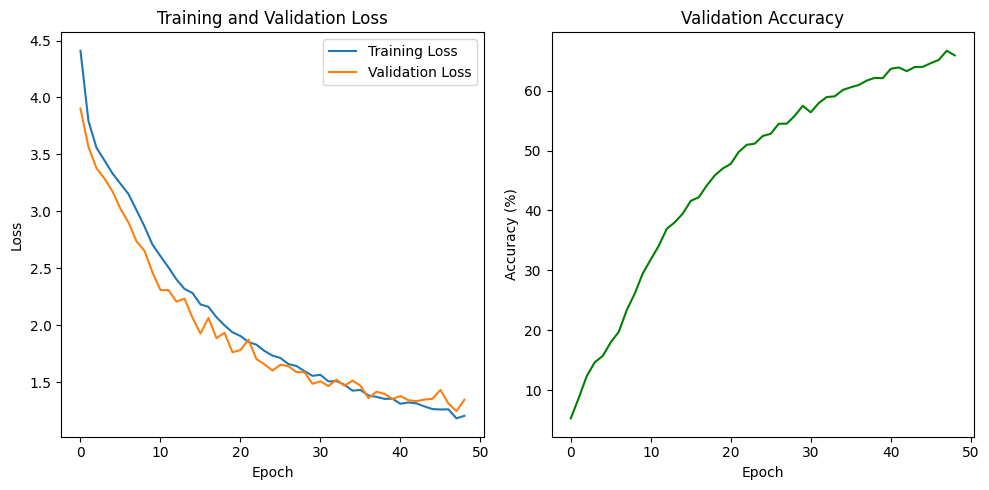

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()


In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for support_set, query_set in validloader:
      support_set, query_set = support_set.to(device), query_set.to(device)
      embeddings = model(support_set)
      _, predicted = torch.max(embeddings, 1)
      total += query_set.size(0)
      correct += (predicted == query_set).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))


Accuracy: 68 %


In [ ]:
# Save the trained model to a file
torch.save(model, './few_shot_learning_model.pth')


In [ ]:
# Create an instance of the CNNModel
model = CNNModel()

# Load the trained model's state dictionary

model = torch.load('few_shot_learning_model.pth').to(device)

model.state_dict()

# Switch the model to evaluation mode
model.eval()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Function to display an image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    image = image.cpu().numpy().transpose((1, 2, 0))  # Move to CPU and convert to numpy
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)
    return ax

# Function to make predictions and display images
def visualize_predictions(model, dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    
    _, preds = torch.max(output, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        imshow(images[i], ax=axes[i], title=f'Predicted: {preds[i].cpu().item()}, Actual: {labels[i].cpu().item()}')  # Move predictions to CPU

# Visualize model predictions on a few validation images
visualize_predictions(model, validloader, num_images=5)


In [ ]:
import matplotlib.pyplot as plt

# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs
